<a href="https://colab.research.google.com/github/antoniovfonseca/summarize-change-components/blob/main/notebooks/beta/summarize_change_components_test5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1.Environment Setup**


---



### **1.1.Install Python Libraries**
Run the cell below only if using Google Colab.


In [1]:
%pip -q install \
    rasterio \
    seaborn \
    xlsxwriter \
    matplotlib-scalebar \
    matplotlib-map-utils

### **1.2.Importing Libraries**

In [2]:
# Standard library
import glob
import os
import re
import pickle
import sys
import time
import math
from pathlib import Path

# Typing for annotations
from typing import Dict, List, Optional, Iterable, Tuple

# Third-party
import numba as nb
import numpy as np
import pandas as pd
import rasterio
import xlsxwriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
from numba import prange
from pyproj import Transformer
from pyproj import CRS, Geod, Transformer
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Rasterio submodules
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.transform import from_origin

# Matplotlib extensions
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow
from matplotlib.colors import (
    ListedColormap,
    BoundaryNorm,
    Normalize,
    LinearSegmentedColormap,
)
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

### **1.3.Mounting Google Drive in Colab**
Run the cell below only if using Google Colab.



In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2.Data Preparation**

### **2.1.Setting Paths to Image Files**

The user must include the year in the raster map name.

In [4]:
# 1. Define the main directory for the toy dataset
input_paths= "/content/drive/MyDrive/Assesssments/cca/input/toydata5"

# 2. Create the directory structure directly
os.makedirs(
    input_paths,
    exist_ok=True
)

# 3. Define toy data values (Rows = Time Points, Columns = Pixels)
# Values represent Classes: A=1, B=2, C=3, D=4
toy_values = np.array(
    [
        [1],  # Time 1: A
        [4],  # Time 2: D
        [1],  # Time 3: A
        [2],  # Time 4: B
        [3],  # Time 5: C
        [4],  # Time 6: D
    ],
    dtype="uint8",
)

noData_value = 255

# 4. Define list of years corresponding to time points
years = [
    "2000",
    "2001",
    "2002",
    "2003",
    "2004",
    "2005"
]

# 5. Setup raster metadata (1 row height, 5 columns width)
width = 1
height = 1
transform = from_origin(
    0,
    0,
    1,
    1
)

image_paths = []

# 6. Save each time point as a GeoTIFF
for idx, t_name in enumerate(
    years
):
    file_path = os.path.join(
        input_paths,
        f"{t_name}.tif"
    )

    # 7. Reshape the 1D pixel row to 2D (1, width)
    data_2d = toy_values[idx].reshape(
        (
            height,
            width
        )
    )

    # 8. Write the data to a GeoTIFF file
    with rasterio.open(
        file_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=data_2d.dtype,
        crs="EPSG:4326",
        transform=transform,
        nodata=noData_value
    ) as dst:
        dst.write(
            data_2d,
            1
        )

    image_paths.append(
        file_path
    )

print(
    "Toy data 5 created successfully."
)
print(
    f"Dimensions: {width} Pixels x {len(years)} Time Points"
)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Toy data 5 created successfully.
Dimensions: 1 Pixels x 6 Time Points


### **2.2.Setting Path to Output Files**

In [5]:
# 1. Define the output path inside the toydata4 directory
output_path = os.path.join(
    "/content/drive/MyDrive/Assesssments/cca/output",
    "toydata5"
)

# 2. Create the output directory structure
os.makedirs(
    output_path,
    exist_ok=True
)

print(
    f"Output directory created at: {output_path}"
)

Output directory created at: /content/drive/MyDrive/Assesssments/cca/output/toydata5


### **2.3.Setting Years of the Time Intervals**

### **2.4.Setting the classes**

In [6]:
# 1. Map integer values to class names A, B, C, D, E
class_labels_dict = {
    1: {
        "name": "A",
        "color": "#1f77b4",
    },
    2: {
        "name": "B",
        "color": "#ff7f0e",
    },
    3: {
        "name": "C",
        "color": "#2ca02c",
    },
    4: {
        "name": "D",
        "color": "#d62728",
    },
    # 5: {
    #     "name": "Class E",
    #     "color": "#9467bd",
    # },
}

# 2. Generate list of class names for the analysis functions
class_names = [
    info["name"]
    for class_id, info in sorted(
        class_labels_dict.items(),
    )
]

print(
    f"Processing labels: {class_names}",
)

Processing labels: ['A', 'B', 'C', 'D']


### **2.4.Apply Mask**
The function applies a binary mask to the input rasters, keeping only the pixels where the mask value equals 1 and setting the others to 0. It then converts the data to 8-bit format and saves the results as LZW-compressed TIFF files.

### **2.5.Display the Maps**

The code defines a function to find files with a given suffix and returns their paths. It then defines a function that plots each raster file with a specified color map, and a legend. It reads the raster data with rasterio, reshapes it, applies the color map, and arranges the images in a single row of subplots. It sets each plot’s title with the provided year, hides the axes, and includes a custom legend. Finally, it saves the plot as a JPEG and displays it.

## **3.Class distribution over time**


---


Pixel counts per time point and class:
ClassName  A  B  C  D
Year                 
2000       1  0  0  0
2001       0  0  0  1
2002       1  0  0  0
2003       0  1  0  0
2004       0  0  1  0
2005       0  0  0  1


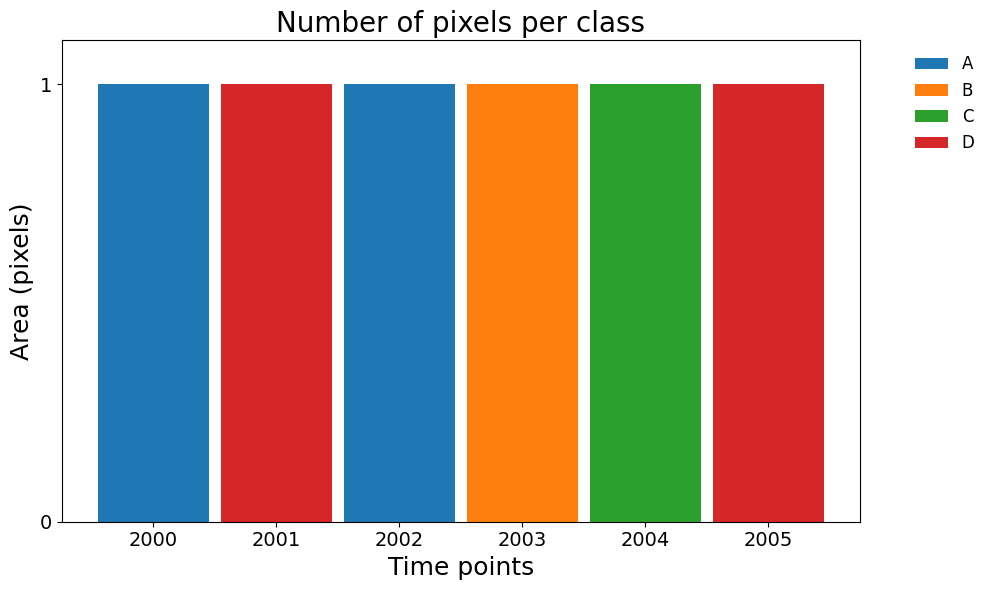

Files saved to: /content/drive/MyDrive/Assesssments/cca/output/toydata5


In [7]:
def process_and_plot_pixel_counts(
    image_paths,
    years,
    class_labels_dict,
    output_dir,
    no_data_value=noData_value,
):
    """
    Processes raster images to count pixels per class, plots a stacked bar chart,
    and exports the results to a CSV file.

    Parameters
    ----------
    image_paths : list of str
        List of file paths to the raster images (must be sorted).
    years : list of str or int
        List of years corresponding to the images.
    class_labels_dict : dict
        Dictionary mapping class IDs to metadata (must contain "name" and "color").
    output_dir : str
        Directory path where the output plot and CSV will be saved.
    no_data_value : int, optional
        Pixel value to be treated as NoData (default is 255).

    Returns
    -------
    pd.DataFrame
        The pivot table containing pixel counts per year and class.
    """
    # 1. Validate that input lengths match
    if len(image_paths) != len(years):
        raise ValueError(
            f"Input mismatch: {len(image_paths)} images vs {len(years)} years.",
        )

    records: list[dict] = []

    # 2. Iterate through each year and corresponding image path
    for year, path in zip(
        years,
        image_paths,
    ):
        # 3. Read the raster data
        with rasterio.open(
            path,
        ) as src:
            data = src.read(
                1,
            )

        # 4. Count unique pixel values
        values, counts = np.unique(
            data,
            return_counts=True,
        )

        # 5. Process counts and map to class names
        for value, count in zip(
            values,
            counts,
        ):
            value = int(value)

            # Filter out NoData values
            if value == no_data_value:
                continue

            # Skip classes not defined in the dictionary
            if value not in class_labels_dict:
                continue

            records.append(
                {
                    "Year": year,
                    "ClassID": value,
                    "ClassName": class_labels_dict[value]["name"],
                    "Pixels": int(count),
                },
            )

    # 6. Create DataFrame and Pivot Table
    df_pixels = pd.DataFrame(
        records,
    )

    pivot_pixels = (
        df_pixels.pivot_table(
            index="Year",
            columns="ClassName",
            values="Pixels",
            aggfunc="sum",
        )
        .fillna(
            0,
        )
        .astype(
            int,
        )
    )

    years_array = pivot_pixels.index.values

    # 7. Determine Y-axis scaling factor and label
    max_val = pivot_pixels.to_numpy().max()

    if max_val >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Area (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000
        y_label = "Area (thousand pixels)"
    elif max_val >= 100:
        scale_factor = 100
        y_label = "Area (hundred pixels)"
    else:
        scale_factor = 1
        y_label = "Area (pixels)"

    pivot_scaled = pivot_pixels / scale_factor

    print(
        "Pixel counts per time point and class:",
    )
    print(
        pivot_pixels,
    )

    # 8. Prepare color map and sorting logic
    class_ids_plot = sorted(
        class_labels_dict.keys(),
    )

    color_map = {
        class_labels_dict[class_id]["name"]: class_labels_dict[class_id]["color"]
        for class_id in class_ids_plot
    }

    # Calculate Net Change
    first_year = years_array[0]
    last_year = years_array[-1]
    net_change_per_class = (
        pivot_scaled.loc[last_year]
        - pivot_scaled.loc[first_year]
    )

    # Map names back to IDs for tie-breaking
    name_to_id_map = {
        v["name"]: k
        for k, v in class_labels_dict.items()
    }

    df_sorting = net_change_per_class.to_frame(
        name="net_change",
    )
    df_sorting["class_id"] = df_sorting.index.map(
        name_to_id_map,
    )

    # Sort: Net Change (Desc) then Class ID (Desc)
    classes_for_stack = list(
        df_sorting.sort_values(
            by=[
                "net_change",
                "class_id",
            ],
            ascending=[
                False,
                False,
            ],
        ).index,
    )

    # Legend order: Reversed stack order
    classes_for_legend = list(
        reversed(classes_for_stack),
    )

    # 9. Generate the Stacked Bar Chart
    fig, ax = plt.subplots(
        figsize=(
            10,
            6,
        ),
    )

    x = np.arange(
        len(years_array),
    )
    width = 0.9
    base = np.zeros(
        len(years_array),
        dtype=float,
    )
    patches_by_class: dict[str, plt.Artist] = {}

    for cls in classes_for_stack:
        if cls not in pivot_scaled.columns:
            continue

        values_cls = pivot_scaled[cls].reindex(
            years_array,
            fill_value=0.0,
        ).values

        bars = ax.bar(
            x,
            values_cls,
            bottom=base,
            width=width,
            label=cls,
            color=color_map.get(cls, "gray"),
        )
        patches_by_class[cls] = bars[0]
        base += values_cls

    # 10. Configure Axes
    ax.set_xticks(
        x,
    )
    ax.set_xticklabels(
        years_array,
    )

    # Adaptive rotation for X-axis labels
    n_labels = len(years_array)
    if n_labels <= 6:
        rotation = 0
        ha = "center"
    elif n_labels <= 12:
        rotation = 45
        ha = "right"
    else:
        rotation = 90
        ha = "center"

    plt.setp(
        ax.get_xticklabels(),
        rotation=rotation,
        ha=ha,
    )

    ax.tick_params(
        axis="both",
        labelsize=14,
    )
    ax.set_ylabel(
        y_label,
        fontsize=18,
    )
    ax.set_xlabel(
        "Time points",
        fontsize=18,
    )
    ax.set_title(
        "Number of pixels per class",
        fontsize=20,
    )

    # Y-axis limit and formatting
    y_max_scaled = base.max() * 1.1 if base.max() > 0 else 1.0
    ax.set_ylim(
        0,
        y_max_scaled,
    )
    ax.yaxis.set_major_locator(
        ticker.MaxNLocator(
            nbins=5,
            integer=True,
        ),
    )
    ax.yaxis.set_major_formatter(
        ticker.FormatStrFormatter(
            "%d",
        ),
    )

    # 11. Add Legend
    handles = [
        patches_by_class[cls]
        for cls in classes_for_legend
        if cls in patches_by_class
    ]
    labels = [
        cls
        for cls in classes_for_legend
        if cls in patches_by_class
    ]

    ax.legend(
        handles,
        labels,
        bbox_to_anchor=(
            1.05,
            1.0,
        ),
        loc="upper left",
        frameon=False,
        fontsize=12,
    )

    plt.tight_layout()

    # 12. Save Figure
    out_fig = os.path.join(
        output_dir,
        "graph_pixel_per_class.png",
    )
    plt.savefig(
        out_fig,
        format="png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

    # 13. Save CSV
    csv_output_path = os.path.join(
        output_dir,
        "pixels_per_class_per_year.csv",
    )
    pivot_pixels.to_csv(
        csv_output_path,
        index_label="Year",
    )
    print(
        f"Files saved to: {output_dir}",
    )

    return pivot_pixels


# 14. Execute the function with the current variables
df_result = process_and_plot_pixel_counts(
    image_paths=image_paths,
    years=years,
    class_labels_dict=class_labels_dict,
    output_dir=output_path,
    no_data_value=noData_value,
)

## **4.Generate the Transition Matrix**


---
In this section, the computer code will generate four different transition matrices. The first one is related to each time interval. The second one is the transition matrix for the temporal extent, which is represented for the first and last time point of the time extent. The third one is a transition matrix that represents the sum of all time intervals. And the last transition matrix is the alternation matrix, which is the sum matrix minus the extent matrix.

Before generate the transition matrix, the computer code will analyze the presence of 0, NULL and NA value in all maps. If there is a presence of one of these values, the computer code will create a mask with these values and will remove all the pixels in the same position in all maps and years.

All the transition matrix will be salved in yput output folder in the ".csv" format.

In [8]:
def generate_mask_and_flatten_rasters(
    input_dir,
    suffix=".tif",
):
    """
    Read rasters by suffix, mask zeros/NaN/nodata, and flatten valid values.

    Parameters
    ----------
    input_dir : str
        Folder containing the raster files.
    suffix : str, optional
        Filename suffix to filter files (default is ".tif").

    Returns
    -------
    tuple of (list of np.ndarray, list of int)
        A tuple containing:
        - List of flattened data arrays.
        - List of years extracted from filenames.
    """
    # 1. Construct search pattern and find files
    search_pattern = os.path.join(
        input_dir,
        f"*{suffix}",
    )
    image_paths = sorted(
        glob.glob(
            search_pattern,
        ),
    )

    if not image_paths:
        raise FileNotFoundError(
            f"No files found with suffix {suffix} in {input_dir}",
        )

    all_data = []
    all_masks = []
    years = []

    # 2. Iterate over found images to read and mask data
    # Note: Ensure 'tqdm' and 're' are imported in your setup cell
    for path in tqdm(
        image_paths,
        desc="Reading and masking rasters",
        unit="raster",
    ):
        # Extract year from filename using regex
        year_match = re.search(
            r"(\d+)",
            os.path.basename(
                path,
            ),
        )
        years.append(
            int(year_match.group(1)) if year_match else 0,
        )

        with rasterio.open(
            path,
        ) as src:
            data = src.read(
                1,
            )
            # Create mask for NoData and NaNs
            mask = (
                (data == noData_value)
                | (data == src.nodata)
                | np.isnan(data.astype(float))
            )
            all_masks.append(
                mask,
            )
            all_data.append(
                data,
            )

    # 3. Combine masks to find pixels valid across all time points
    combined_mask = np.any(
        all_masks,
        axis=0,
    )

    # 4. Flatten data, excluding masked pixels
    flattened = [
        data[~combined_mask].flatten() if np.any(combined_mask) else data.flatten()
        for data in all_data
    ]

    return flattened, years


def generate_all_matrices(
    input_path,
    output_path,
    suffix=".tif",
):
    """
    Generate transition matrices using Hybrid Decomposition logic.

    Logic:
    1. Extent: Decomposed Aggregately (Pontius Slide 4).
       Captures swaps between different pixels (e.g., A->C and C->A).
    2. Alternation: Decomposed Per-Pixel (Pontius Slide 9 & 10).
       Preserves trajectory identity (e.g., A->B->C is Shift, not Exchange).

    Parameters
    ----------
    input_path : str
        Directory containing input rasters.
    output_path : str
        Directory to save the output CSV matrices.
    suffix : str, optional
        File suffix for rasters (default is ".tif").

    Returns
    -------
    tuple
        (years, all_classes) lists used in processing.
    """
    # 5. Load and flatten raster data
    flattened_data, years = generate_mask_and_flatten_rasters(
        input_path,
        suffix,
    )

    # 6. Identify all unique classes across the timeline
    all_classes = np.unique(
        np.concatenate(
            flattened_data,
        ),
    ).astype(int)

    n = len(all_classes)
    class_to_idx = {
        cls: i
        for i, cls in enumerate(all_classes)
    }

    # 7. Initialize accumulation matrices
    mat_sum = np.zeros(
        (n, n),
    )
    mat_ext = np.zeros(
        (n, n),
    )
    mat_ax = np.zeros(
        (n, n),
    )
    mat_as = np.zeros(
        (n, n),
    )

    interval_matrices = {
        f"{years[t]}-{years[t+1]}": np.zeros((n, n))
        for t in range(len(years) - 1)
    }

    # 8. Process pixel trajectories
    num_pixels = len(
        flattened_data[0],
    )

    for r in range(
        num_pixels,
    ):
        # Extract trajectory for pixel r
        traj = [
            int(flattened_data[t][r])
            for t in range(len(flattened_data))
        ]
        start_idx = class_to_idx[
            traj[0]
        ]
        end_idx = class_to_idx[
            traj[-1]
        ]

        # Calculate Individual Pixel Matrices
        m_r = np.zeros(
            (n, n),
        )
        for t in range(
            len(traj) - 1,
        ):
            s = class_to_idx[
                traj[t]
            ]
            e = class_to_idx[
                traj[t+1]
            ]
            m_r[
                s,
                e,
            ] += 1
            interval_matrices[
                f"{years[t]}-{years[t+1]}"
            ][
                s,
                e,
            ] += 1

        # Calculate End-to-End matrix for pixel r
        e_r = np.zeros(
            (n, n),
        )
        e_r[
            start_idx,
            end_idx,
        ] += 1

        # Accumulate Aggregates
        mat_sum += m_r
        mat_ext += e_r

        # 9. Pixel-Level Decomposition for Alternation (Eq 4, 5, 6)
        a_r = m_r - e_r

        # Ax_r = min(A_r, A_r.T), clamped to 0
        ax_r = np.maximum(0, np.minimum(m_r, m_r.T))

        # As_r = A_r - Ax_r
        as_r = a_r - ax_r

        # Accumulate alternation components
        mat_ax += ax_r
        mat_as += as_r

    # 10. Aggregate Decomposition for Extent (Eq 1 & 2)
    # Applied on the total Extent matrix to capture inter-pixel swaps
    mat_ex = np.maximum(
        0,
        np.minimum(
            mat_ext,
            mat_ext.T,
        ),
    )
    mat_es = mat_ext - mat_ex

    # 11. Save matrices to CSV
    # A) Save individual intervals
    for interval_name, mat in interval_matrices.items():
        fname = f"transition_matrix_{interval_name}.csv"
        out_csv = os.path.join(
            output_path,
            fname,
        )
        pd.DataFrame(
            mat,
            index=all_classes,
            columns=all_classes,
        ).to_csv(
            out_csv,
        )

    # B) Save aggregated components
    interval_str = f"{years[0]}-{years[-1]}"
    aggregated = {
        "sum": mat_sum,
        "extent": mat_ext,
        "allocation_exchange": mat_ex,
        "allocation_shift": mat_es,
        "alternation_exchange": mat_ax,
        "alternation_shift": mat_as,
    }

    for name, mat in aggregated.items():
        fname = f"transition_matrix_{name}_{interval_str}.csv"
        out_csv = os.path.join(
            output_path,
            fname,
        )
        pd.DataFrame(
            mat,
            index=all_classes,
            columns=all_classes,
        ).to_csv(
            out_csv,
        )

    return years, all_classes


# 12. Execute the generation function
print(
    "Generating matrices...",
)
# Using input_paths directly as requested
years_out, all_classes = generate_all_matrices(
    input_path=input_paths,
    output_path=output_path,
    suffix=".tif",
)
print(
    f"Success. Files saved with suffix: {years_out[0]}-{years_out[-1]}",
)

Generating matrices...


Reading and masking rasters: 100%|██████████| 6/6 [00:00<00:00, 67.43raster/s]


Success. Files saved with suffix: 2000-2005


## **5.Heat Maps**


---

### 5.1 Functions

In [9]:
# 1. Validate global inputs
assert isinstance(
    years,
    (
        list,
        tuple,
    ),
) and len(years) >= 2, "`years` missing or invalid."

assert isinstance(
    output_path,
    str,
) and output_path, "`output_path` missing or invalid."

assert isinstance(
    class_labels_dict,
    dict,
) and class_labels_dict, "`class_labels_dict` missing or invalid."


# 2. Helper to extract year digits for filename matching
def _extract_year_str(
    val,
) -> str:
    """
    Extract the first sequence of digits from a year string or integer.

    Parameters
    ----------
    val : str or int
        The value containing the year (e.g., "time_2000" or 2000).

    Returns
    -------
    str
        The extracted year digits.
    """
    match = re.search(
        r"(\d+)",
        str(val),
    )
    return match.group(1) if match else str(val)


str_y0 = _extract_year_str(
    years[0],
)
str_y1 = _extract_year_str(
    years[-1],
)

# 3. Define paths for all 6 generated matrices
CSV_SUM = os.path.join(
    output_path,
    f"transition_matrix_sum_{str_y0}-{str_y1}.csv",
)
CSV_EXT = os.path.join(
    output_path,
    f"transition_matrix_extent_{str_y0}-{str_y1}.csv",
)
CSV_EXT_EXC = os.path.join(
    output_path,
    f"transition_matrix_allocation_exchange_{str_y0}-{str_y1}.csv",
)
CSV_EXT_SHIFT = os.path.join(
    output_path,
    f"transition_matrix_allocation_shift_{str_y0}-{str_y1}.csv",
)
CSV_ALT_EXC = os.path.join(
    output_path,
    f"transition_matrix_alternation_exchange_{str_y0}-{str_y1}.csv",
)
CSV_ALT_SHIFT = os.path.join(
    output_path,
    f"transition_matrix_alternation_shift_{str_y0}-{str_y1}.csv",
)

# 4. Check for existence of all required files
required_files = [
    CSV_SUM,
    CSV_EXT,
    CSV_EXT_EXC,
    CSV_EXT_SHIFT,
    CSV_ALT_EXC,
    CSV_ALT_SHIFT,
]

for path_csv in required_files:
    if not os.path.exists(path_csv):
        raise FileNotFoundError(
            f"Missing required CSV: {path_csv}",
        )

print(
    "Found all base CSVs.",
)


def load_square_matrix(
    csv_path: str,
) -> pd.DataFrame:
    """
    Load a square transition matrix from CSV and align row/column labels.

    Parameters
    ----------
    csv_path : str
        Path to a CSV file where the first column and the header row
        contain class IDs (or labels), and the remaining cells contain
        transition counts.

    Returns
    -------
    pd.DataFrame
        Square DataFrame with string labels on both rows and columns.
        When row and column labels differ, their union is used and
        missing cells are filled with 0.0.
    """
    df = pd.read_csv(
        csv_path,
        index_col=0,
    )
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)

    if list(df.index) != list(df.columns):
        labels = sorted(
            set(df.index).union(df.columns),
            key=lambda x: int(x),
        )
        df = df.reindex(
            index=labels,
            columns=labels,
        ).fillna(0.0)

    if df.shape[0] != df.shape[1]:
        raise ValueError(
            f"Matrix not square after alignment: {csv_path}",
        )

    return df


def label_id_to_name(
    labels: Iterable[str],
) -> list[str]:
    """
    Map class ID strings to human-readable names using ``class_labels_dict``.

    Parameters
    ----------
    labels : Iterable[str]
        Class IDs as strings (e.g. ``["0", "1", "2"]``).

    Returns
    -------
    list[str]
        List of class names mapped from IDs.
    """
    id_to_name = {
        int(k): v.get(
            "rename",
            v.get(
                "name",
                str(k),
            ),
        )
        for k, v in class_labels_dict.items()
    }

    names: list[str] = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(
                id_to_name.get(
                    cid,
                    str(lab),
                ),
            )
        except Exception:
            names.append(str(lab))

    return names


def compute_net_change_from_sum(
    df_sum: pd.DataFrame,
) -> pd.Series:
    """
    Compute net change per class from a SUM transition matrix.

    Parameters
    ----------
    df_sum : pd.DataFrame
        Square transition matrix representing total transitions over
        the full time span.

    Returns
    -------
    pd.Series
        Net change for each class (gains - losses).
    """
    M = df_sum.values.astype(float).copy()

    # Remove persistence on the diagonal for the calculation
    np.fill_diagonal(
        M,
        0.0,
    )

    gains = M.sum(
        axis=0,
    )
    losses = M.sum(
        axis=1,
    )

    net_change = gains - losses

    return pd.Series(
        net_change,
        index=df_sum.index,
    )


def reorder_matrices_by_net_change(
    df_sum: pd.DataFrame,
    df_ext: pd.DataFrame,
    df_ext_exc: pd.DataFrame,
    df_ext_shift: pd.DataFrame,
    df_alt_exc: pd.DataFrame,
    df_alt_shift: pd.DataFrame,
) -> tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
]:
    """
    Reorder rows and columns of all matrices using net change from ``df_sum``.

    Parameters
    ----------
    df_sum : pd.DataFrame
        SUM transition matrix (used for sorting logic).
    df_ext : pd.DataFrame
        Extent matrix.
    df_ext_exc : pd.DataFrame
        Extent Exchange matrix.
    df_ext_shift : pd.DataFrame
        Extent Shift matrix.
    df_alt_exc : pd.DataFrame
        Alternation Exchange matrix.
    df_alt_shift : pd.DataFrame
        Alternation Shift matrix.

    Returns
    -------
    tuple[pd.DataFrame, ...]
        All input dataframes reindexed so that:
        - largest losers (most negative net change) are at the top/left.
        - largest gainers (most positive net change) are at the bottom/right.
    """
    net_change = compute_net_change_from_sum(
        df_sum=df_sum,
    )
    order_labels = (
        net_change.sort_values(
            ascending=True,
        )
        .index.tolist()
    )

    def _reorder(
        df: pd.DataFrame,
    ) -> pd.DataFrame:
        return df.reindex(
            index=order_labels,
            columns=order_labels,
        )

    return (
        _reorder(df_sum),
        _reorder(df_ext),
        _reorder(df_ext_exc),
        _reorder(df_ext_shift),
        _reorder(df_alt_exc),
        _reorder(df_alt_shift),
    )


def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
) -> None:
    """
    Annotate a heatmap with integer cell values and adaptive text color.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object where the heatmap is plotted.
    M : np.ndarray
        The matrix containing the values to display.
    fontsize : int, optional
        The font size of the annotations (default is 8).

    Returns
    -------
    None
    """
    if M.size == 0:
        return

    M_off = M.copy()
    np.fill_diagonal(
        M_off,
        np.nan,
    )
    data_off = M_off[np.isfinite(M_off)]

    has_pos = np.any(data_off > 0)
    has_neg = np.any(data_off < 0)

    max_pos = float(np.nanmax(data_off[data_off > 0])) if has_pos else 0.0
    min_neg = float(np.nanmin(data_off[data_off < 0])) if has_neg else 0.0

    thresh_pos = 0.5 * max_pos if has_pos else np.inf
    thresh_neg = 0.5 * min_neg if has_neg else -np.inf

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            # Skip diagonal annotation to keep it clean black
            if i == j:
                continue

            v = float(M[i, j])
            txt = f"{int(round(v))}"

            if i == j:
                color = "white"
            else:
                if (
                    has_pos
                    and v >= thresh_pos
                ) or (
                    has_neg
                    and v <= thresh_neg
                ):
                    color = "white"
                else:
                    color = "black"

            ax.text(
                j,
                i,
                txt,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=color,
                clip_on=True,
            )


def _unit_label(
    suffix: str,
    base_label: str = "number of pixels",
) -> str:
    """
    Build a descriptive label for the colorbar based on a unit suffix.

    Parameters
    ----------
    suffix : str
        The suffix for the unit (e.g., 'k', 'M').
    base_label : str, optional
        The base label text (default is "Number of pixels").

    Returns
    -------
    str
        The formatted unit label.
    """
    mapping = {
        "": base_label,
        "k": "thousand pixels",
        "M": "million pixels",
        "B": "billion pixels",
        "T": "trillions pixels",
    }

    return mapping.get(
        suffix,
        f"{base_label} ({suffix})",
    )


def _unit_formatter(
    factor: float,
    suffix: str,
    decimals: int = 1,
) -> mticker.FuncFormatter:
    """
    Build a tick formatter that scales values and appends a suffix.

    Parameters
    ----------
    factor : float
        The factor to divide the values by (e.g., 1000 for 'k').
    suffix : str
        The string suffix to append to the formatted value.
    decimals : int, optional
        The number of decimal places to include (default is 1).

    Returns
    -------
    matplotlib.ticker.FuncFormatter
        A formatter function for the plot ticks.
    """
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(
        x: float,
        pos: int,
    ) -> str:
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Optional[str] = None,
    figsize: Optional[Tuple[float, float]] = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: Optional[float] = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: Optional[int] = None,
    ann_fontsize: int = 8,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: Optional[int] = None,
    tick_fontsize_y: Optional[int] = None,
    axis_label_fontsize: Optional[int] = None,
    title_fontsize: Optional[int] = None,
) -> None:
    """
    Plot a square matrix as a heatmap with adaptive integer colorbar and dual scaling.

    Parameters
    ----------
    df : pd.DataFrame
        The square dataframe to plot.
    title : str
        The title of the plot.
    save_path : str, optional
        Path to save the figure image.
    figsize : tuple, optional
        Figure size in inches (width, height).
    cmap : str, optional
        Colormap name (default is "YlOrRd").
    vmin : float, optional
        Minimum value for colormap scaling.
    vmax : float, optional
        Maximum value for colormap scaling.
    rotate_xticks_deg : int, optional
        Rotation angle for x-axis ticks.
    cbar_label : str, optional
        Label for the colorbar.
    annotate : bool, optional
        Whether to annotate cells with values.
    cell_size_inch : float, optional
        Size of each cell in inches used for auto-figsize.
    tick_fontsize : int, optional
        Deprecated; use tick_fontsize_x/y.
    ann_fontsize : int, optional
        Font size for annotations.
    cbar_fraction : float, optional
        Fraction of original axes to use for colorbar.
    cbar_pad : float, optional
        Padding between axes and colorbar.
    tick_fontsize_x : int, optional
        Font size for x-axis ticks.
    tick_fontsize_y : int, optional
        Font size for y-axis ticks.
    axis_label_fontsize : int, optional
        Font size for axis labels.
    title_fontsize : int, optional
        Font size for the title.

    Returns
    -------
    None
    """
    if tick_fontsize_x is None or tick_fontsize_y is None:
        raise ValueError(
            "Set `tick_fontsize_x` and `tick_fontsize_y` explicitly.",
        )

    if axis_label_fontsize is None:
        axis_label_fontsize = 12

    if title_fontsize is None:
        title_fontsize = 14

    labels = list(
        df.index,
    )
    matrix_values = df.values.astype(
        float,
    )

    # Prepare scale ignoring diagonal to highlight transitions
    matrix_scale = matrix_values.copy()
    np.fill_diagonal(
        matrix_scale,
        0.0,
    )
    finite_vals = matrix_scale[
        np.isfinite(
            matrix_scale,
        )
    ]

    # Define effective limits for the color scale
    if finite_vals.size == 0:
        has_negative = False
        vmin_eff, vmax_eff = 0.0, 1.0
    else:
        has_negative = float(np.nanmin(finite_vals)) < 0.0
        min_val = float(np.nanmin(finite_vals))
        max_val = float(np.nanmax(finite_vals))

        if has_negative:
            # Use data bounds for divergent scaling
            vmin_eff, vmax_eff = min_val, max_val
        else:
            vmin_eff = vmin
            vmax_eff = float(max_val) if vmax is None else float(vmax)

        if vmin_eff == vmax_eff:
            vmax_eff += 1.0

    nrows, ncols = df.shape
    if figsize is None:
        figsize = (
            cell_size_inch * ncols,
            cell_size_inch * nrows,
        )

    fig, ax = plt.subplots(
        figsize=figsize,
        constrained_layout=True,
    )

    # Plot layers (Negative in Blues, Positive in YlOrRd)
    cmap_neg = mcolors.LinearSegmentedColormap.from_list("CustomBlues", ["#08306b", "#b3e0ff"])
    # Plot layers (Negative in Blues, Positive in YlOrRd)
    if has_negative:
        matrix_pos = np.ma.masked_less_equal(matrix_values, 0.0)
        norm_pos = mcolors.Normalize(vmin=0.0, vmax=vmax_eff)
        ax.imshow(
            matrix_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )
        matrix_neg = np.ma.masked_where(matrix_values >= 0.0, matrix_values)
        norm_neg = mcolors.Normalize(vmin=vmin_eff, vmax=0.0)
        ax.imshow(
            matrix_neg,
            aspect="equal",
            cmap=cmap_neg,
            norm=norm_neg,
        )
    else:
        matrix_pos = np.ma.masked_equal(matrix_values, 0.0)
        norm_pos = mcolors.Normalize(vmin=vmin_eff, vmax=vmax_eff)
        ax.imshow(
            matrix_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

    # Overlay black diagonal
    diag_mask = np.eye(nrows, dtype=bool)
    matrix_diag = np.ma.masked_where(~diag_mask, np.ones_like(matrix_values))
    ax.imshow(
        matrix_diag,
        aspect="equal",
        cmap=mcolors.ListedColormap(["black"]),
        vmin=0,
        vmax=1,
    )

    # Axis formatting
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    tick_names = label_id_to_name(labels)

    ax.set_xticklabels(
        tick_names,
        rotation=rotate_xticks_deg,
        fontsize=tick_fontsize_x,
    )
    ax.set_yticklabels(
        tick_names,
        fontsize=tick_fontsize_y,
    )
    ax.set_xlabel("To class", fontsize=axis_label_fontsize)
    ax.set_ylabel("From class", fontsize=axis_label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)

    # Build continuous colorbar
    n_bar = 256
    vals = np.linspace(vmin_eff, vmax_eff, n_bar)
    colors_bar = []
    for v in vals:
        if has_negative and v < 0.0:
            # Scale negative values to Blues map
            t = (v - vmin_eff) / (0.0 - vmin_eff) if vmin_eff < 0 else 0
            colors_bar.append(cmap_neg(t))
        elif v == 0:
          colors_bar.append((1.0, 1.0, 1.0, 1.0))
        else:
            # Scale positive values to YlOrRd map
            t = max(0.0, v) / vmax_eff if vmax_eff > 0.0 else 0.0
            colors_bar.append(plt.cm.YlOrRd(t))

    cmap_bar = mcolors.ListedColormap(colors_bar)
    norm_bar = mcolors.Normalize(vmin=vmin_eff, vmax=vmax_eff)
    scalar_mappable = plt.cm.ScalarMappable(cmap=cmap_bar, norm=norm_bar)
    scalar_mappable.set_array([])

    # Create Colorbar
    cbar = fig.colorbar(
        scalar_mappable,
        ax=ax,
        fraction=cbar_fraction,
        pad=cbar_pad,
    )

    # Adaptive unit scaling
    max_abs = float(np.nanmax(np.abs(finite_vals))) if finite_vals.size > 0 else 0.0
    if max_abs >= 1_000_000:
        factor, suffix = 1_000_000.0, "M"
    elif max_abs >= 1_000:
        factor, suffix = 1_000.0, "k"
    elif max_abs >= 100:
        factor, suffix = 100.0, "hundreds"
    else:
        factor, suffix = 1.0, ""

    # Use Integer Locator correctly for Toy Data and small ranges
    cbar.locator = mticker.MaxNLocator(
        nbins=5,
        integer=True,
        steps=[1, 2, 5, 10],
    )
    cbar.formatter = _unit_formatter(
        factor=factor,
        suffix="",
        decimals=0,
    )
    cbar.set_label(
        _unit_label(suffix, base_label=cbar_label),
        rotation=270,
        labelpad=15,
        fontsize=12,
    )
    cbar.update_ticks()

    if annotate:
        annotate_heatmap(
            ax=ax,
            M=matrix_values,
            fontsize=ann_fontsize,
        )

    if save_path:
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()

Found all base CSVs.


### 5.2 Compute Exchange matrix

In [10]:
# 1. Load the base Sum and Extent matrices
df_sum = load_square_matrix(
    CSV_SUM,
)
df_ext = load_square_matrix(
    CSV_EXT,
)

# 2. Load the 4 Decomposed Component Matrices
df_ext_exc = load_square_matrix(
    CSV_EXT_EXC,
)
df_ext_shift = load_square_matrix(
    CSV_EXT_SHIFT,
)
df_alt_exc = load_square_matrix(
    CSV_ALT_EXC,
)
df_alt_shift = load_square_matrix(
    CSV_ALT_SHIFT,
)

# 3. Reorder all matrices based on Net Change (Losers to Gainers)
# This function (defined in the previous cell) ensures all 6 matrices
# share the exact same row/column order for consistent visualization.
(
    df_sum,
    df_ext,
    df_ext_exc,
    df_ext_shift,
    df_alt_exc,
    df_alt_shift,
) = reorder_matrices_by_net_change(
    df_sum=df_sum,
    df_ext=df_ext,
    df_ext_exc=df_ext_exc,
    df_ext_shift=df_ext_shift,
    df_alt_exc=df_alt_exc,
    df_alt_shift=df_alt_shift,
)

print(
    "Successfully loaded and reordered all 6 matrices:",
)
print(
    "1. Sum",
)
print(
    "2. Extent",
)
print(
    "3. Allocation Exchange",
)
print(
    "4. Quantity & Allocation Shift",
)
print(
    "5. Alternation Exchange",
)
print(
    "6. Alternation Shift",
)

Successfully loaded and reordered all 6 matrices:
1. Sum
2. Extent
3. Allocation Exchange
4. Quantity & Allocation Shift
5. Alternation Exchange
6. Alternation Shift


### 5.3 Plot Heat Maps

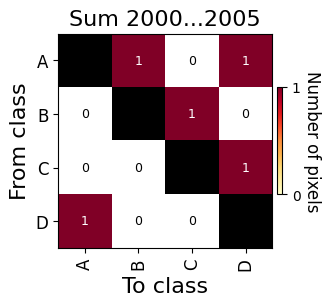

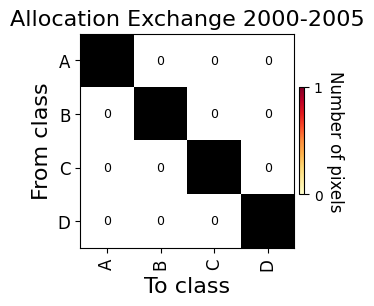

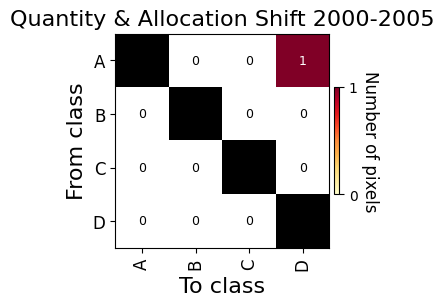

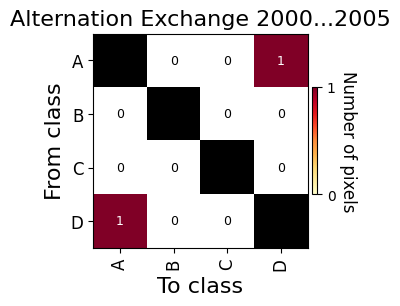

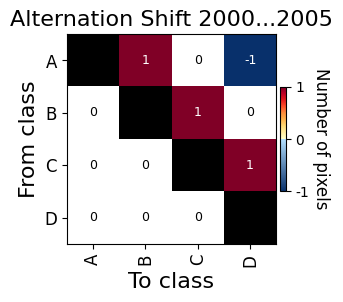

Saved all heat maps:
1. /content/drive/MyDrive/Assesssments/cca/output/toydata5/heatmap_sum_2000-2005.png
2. /content/drive/MyDrive/Assesssments/cca/output/toydata5/heatmap_allocation_exchange_2000-2005.png
3. /content/drive/MyDrive/Assesssments/cca/output/toydata5/heatmap_quantiy_allocation_shift_2000-2005.png
4. /content/drive/MyDrive/Assesssments/cca/output/toydata5/heatmap_alternation_exchange_2000...2005.png
5. /content/drive/MyDrive/Assesssments/cca/output/toydata5/heatmap_alternation_shift_2000...2005.png


In [11]:
# 1. Define start and end years for file naming
Y0 = years[0]
Y1 = years[-1]

# 2. Define Output Paths using os.path.join for consistency
# Sum Matrix
FIG_SUM = os.path.join(
    output_path,
    f"heatmap_sum_{Y0}-{Y1}.png",
)

# Allocation components
FIG_EXT_EXC = os.path.join(
    output_path,
    f"heatmap_allocation_exchange_{Y0}-{Y1}.png",
)
FIG_EXT_SHIFT = os.path.join(
    output_path,
    f"heatmap_quantiy_allocation_shift_{Y0}-{Y1}.png",
)

# Alternation components
FIG_ALT_EXC = os.path.join(
    output_path,
    f"heatmap_alternation_exchange_{Y0}...{Y1}.png",
)
FIG_ALT_SHIFT = os.path.join(
    output_path,
    f"heatmap_alternation_shift_{Y0}...{Y1}.png",
)

# 3. List of matrices to plot
# Note: Using variable names from the previous cell (e.g., df_sum instead of df_sum_plot)
plots_config = [
    (
        df_sum,
        f"Sum {Y0}...{Y1}",
        FIG_SUM,
    ),
    (
        df_ext_exc,
        f"Allocation Exchange {Y0}-{Y1}",
        FIG_EXT_EXC,
    ),
    (
        df_ext_shift,
        f"Quantity & Allocation Shift {Y0}-{Y1}",
        FIG_EXT_SHIFT,
    ),
    (
        df_alt_exc,
        f"Alternation Exchange {Y0}...{Y1}",
        FIG_ALT_EXC,
    ),
    (
        df_alt_shift,
        f"Alternation Shift {Y0}...{Y1}",
        FIG_ALT_SHIFT,
    ),
]

# 4. Iterate and plot each heatmap
for df, title, path in plots_config:
    plot_heatmap(
        df=df,
        title=title,
        save_path=path,
        tick_fontsize_x=12,
        tick_fontsize_y=12,
        axis_label_fontsize=16,
        title_fontsize=16,
        ann_fontsize=9,
        cbar_fraction=0.025,
        cbar_pad=0.02,
    )

print(
    "Saved all heat maps:",
)
print(
    f"1. {FIG_SUM}",
)
print(
    f"2. {FIG_EXT_EXC}",
)
print(
    f"3. {FIG_EXT_SHIFT}",
)
print(
    f"4. {FIG_ALT_EXC}",
)
print(
    f"5. {FIG_ALT_SHIFT}",
)

## **6.Components of Change**


---
The code calculates components of change from transition matrices generated in the previous step. It features a ComponentCalculator class that processes matrices to determine the gain and loss of Quantity, Exchange, and Shift. The process_matrix function handles matrices for defined time intervals and the main function systematically processes these matrices for each time interval, aggregates the results, and exports the outcomes to a CSV file.

#### 6.1 Compute components of change

In [12]:
class ComponentCalculator:
    """
    Compute change components (Quantity, Exchange, Shift) for a matrix.

    Supports pre-decomposed matrices via force_component parameter.
    """

    def __init__(
        self,
        transition_matrix: np.ndarray,
    ) -> None:
        """
        Initialize the calculator with a transition matrix.

        Parameters
        ----------
        transition_matrix : np.ndarray
            Square matrix representing transitions.
        """
        self.matrix = transition_matrix.astype(
            float,
        )
        self.num_classes = transition_matrix.shape[0]
        self.class_components: list[dict] = []

    def calculate_components(
        self,
        force_component: str = None,
    ) -> "ComponentCalculator":
        """
        Calculate gain, loss, exchange, and shift for all classes.

        Parameters
        ----------
        force_component : str, optional
            If set to "Exchange" or "Shift", forces the interpretation of the
            matrix content to that specific component.

        Returns
        -------
        ComponentCalculator
            Returns self for chaining.
        """
        for class_idx in range(
            self.num_classes,
        ):
            gain_sum = np.sum(
                self.matrix[:, class_idx],
            )
            loss_sum = np.sum(
                self.matrix[class_idx, :],
            )

            # Standard net change calculation
            q_gain = max(
                0.0,
                gain_sum - loss_sum,
            )
            q_loss = max(
                0.0,
                loss_sum - gain_sum,
            )

            if force_component == "Exchange":
                # Matrix content is treated purely as exchange
                exchange = loss_sum - self.matrix[class_idx, class_idx]
                shift = 0.0
                q_gain, q_loss = (
                    gain_sum - loss_sum
                ), (
                    loss_sum - gain_sum
                )
            elif force_component == "Shift":
                # Matrix content is treated purely as shift
                exchange = 0.0
                shift = loss_sum - self.matrix[class_idx, class_idx]
                q_gain, q_loss = 0.0, 0.0
            else:
                # Standard Pontius decomposition
                mutual = np.sum(
                    np.minimum(
                        self.matrix[class_idx, :],
                        self.matrix[:, class_idx],
                    ),
                )
                exchange = mutual - self.matrix[class_idx, class_idx]
                total_trans = loss_sum - self.matrix[class_idx, class_idx]
                shift = total_trans - q_loss - exchange

            self.class_components.append(
                {
                    "Quantity_Gain": q_gain,
                    "Quantity_Loss": q_loss,
                    "Exchange_Gain": exchange,
                    "Exchange_Loss": exchange,
                    "Shift_Gain": shift,
                    "Shift_Loss": shift,
                },
            )
        return self


def process_matrix(
    matrix_type,
    output_path,
    years_list,
    start_year=None,
    end_year=None,
):
    """
    Search for a transition matrix file and calculate its change components.

    Parameters
    ----------
    matrix_type : str
        Type of matrix ("interval", "extent", "sum", etc.).
    output_path : str
        Directory where CSV files are stored.
    years_list : list
        List of all years in the timeline.
    start_year : str or int, optional
        Start year for interval matrices.
    end_year : str or int, optional
        End year for interval matrices.

    Returns
    -------
    list[dict]
        List of dictionaries containing component values per class.
    """
    results = []

    # 1. Determine naming patterns to search for (Short vs Long names)
    patterns = []

    if matrix_type == "interval":
        # Try "time_0-time_1" AND "0-1"
        s_str, e_str = str(start_year), str(end_year)
        patterns.append(
            f"transition_matrix_{s_str}-{e_str}.csv",
        )
        patterns.append(
            f"transition_matrix_{s_str.replace('time_', '')}-{e_str.replace('time_', '')}.csv",
        )
        label_time = f"{s_str}-{e_str}"
    else:
        # Try "sum_time_0-time_2" AND "sum_0-2"
        y0_str, yN_str = str(years_list[0]), str(years_list[-1])
        patterns.append(
            f"transition_matrix_{matrix_type}_{y0_str}-{yN_str}.csv",
        )
        patterns.append(
            f"transition_matrix_{matrix_type}_{y0_str.replace('time_', '')}-{yN_str.replace('time_', '')}.csv",
        )
        label_time = matrix_type

    # 2. Find the existing file
    full_path = None
    for p in patterns:
        path = os.path.join(
            output_path,
            p,
        )
        if os.path.exists(path):
            full_path = path
            break

    if not full_path:
        return []

    # 3. Process components
    force_comp = (
        "Exchange"
        if "exchange" in matrix_type
        else ("Shift" if "shift" in matrix_type else None)
    )

    df_mat = pd.read_csv(
        full_path,
        index_col=0,
    )
    calc = ComponentCalculator(
        df_mat.values,
    ).calculate_components(
        force_component=force_comp,
    )

    for idx, class_id in enumerate(
        [int(c) for c in df_mat.index],
    ):
        # Use simple "Class X" if class_labels_dict is missing or generic
        cls_name = class_labels_dict.get(
            class_id,
            {},
        ).get(
            "name",
            f"Class {class_id}",
        )
        comp_vals = calc.class_components[idx]

        for comp_name in ["Quantity", "Exchange", "Shift"]:
            # Standardize component labels for the plot
            label_comp = comp_name
            if matrix_type in ["extent", "sum"]:
                label_comp = f"Allocation_{comp_name}"
            if "alternation" in matrix_type:
                label_comp = f"Alternation_{comp_name}"

            results.append(
                {
                    "Time_Interval": label_time,
                    "Class": cls_name,
                    "Component": label_comp,
                    "Gain": comp_vals[f"{comp_name}_Gain"],
                    "Loss": comp_vals[f"{comp_name}_Loss"],
                },
            )
    return results


def main(
    output_path,
):
    """
    Main execution function to process all interval and aggregate matrices.

    Parameters
    ----------
    output_path : str
        Path to the output directory.
    """
    all_results = []
    # 1) Annual Intervals
    for i in range(
        len(years) - 1,
    ):
        # Apply Item 6: Clean year extraction for intervals
        # Assuming _extract_year_str is defined in previous cells
        y_start = _extract_year_str(
            years[i],
        )
        y_end = _extract_year_str(
            years[i + 1],
        )

        all_results.extend(
            process_matrix(
                "interval",
                output_path,
                years,
                y_start,
                y_end,
            ),
        )

    # 2) Aggregated Matrices
    for mtype in [
        "extent",
        "sum",
        "alternation_exchange",
        "alternation_shift",
    ]:
        all_results.extend(
            process_matrix(
                mtype,
                output_path,
                years,
            ),
        )

    df_out = pd.DataFrame(
        all_results,
    )
    output_file = os.path.join(
        output_path,
        "change_components.csv",
    )
    df_out.to_csv(
        output_file,
        index=False,
    )
    print(
        f"Success! Final components saved to {output_file}",
    )


# Execute main function
main(
    output_path=output_path,
)

Success! Final components saved to /content/drive/MyDrive/Assesssments/cca/output/toydata5/change_components.csv


#### 6.2 Plot graphics




In [13]:
# Read change components CSV
csv_path = os.path.join(
    output_path,
    "change_components.csv",
)

# Validate path
if not os.path.exists(csv_path):
    raise FileNotFoundError(
        f"CSV not found: {csv_path}",
    )

print(f"Loaded change components from: {csv_path}")

# Load into DataFrame
df = pd.read_csv(
    csv_path,
)

Loaded change components from: /content/drive/MyDrive/Assesssments/cca/output/toydata5/change_components.csv


##### 6.2.1 Change Components by Time Interval

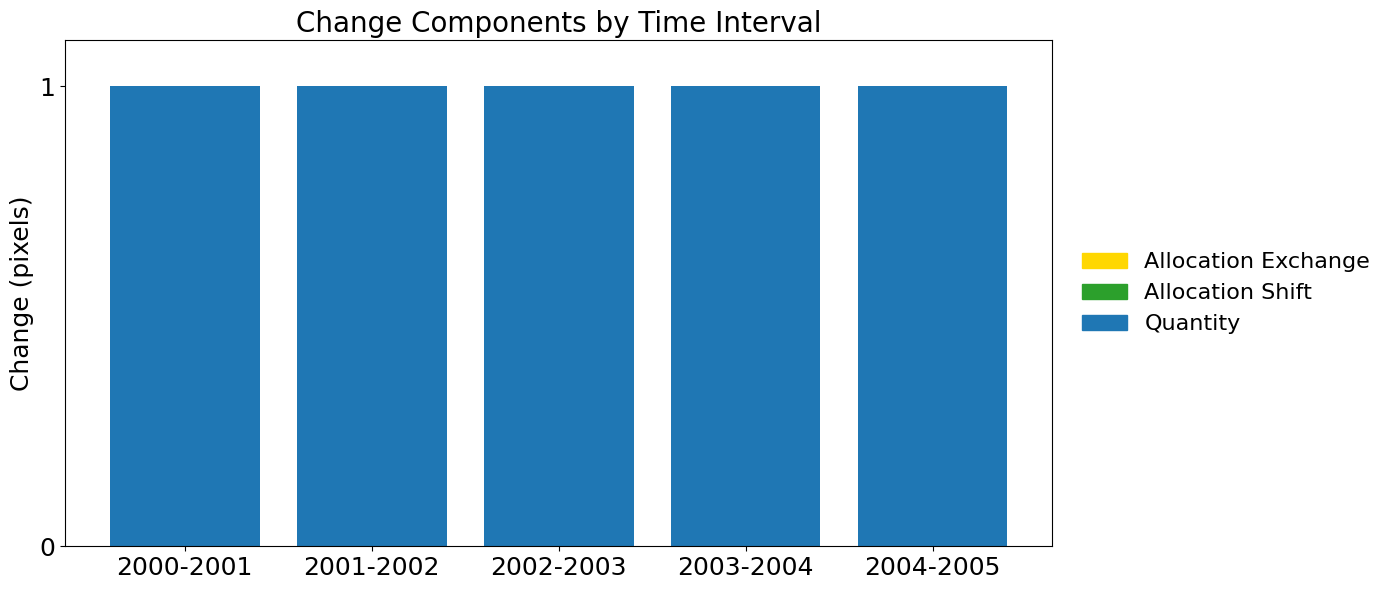

In [14]:
def plot_change_components_by_interval(
    df: pd.DataFrame,
    output_path: str,
) -> None:
    """
    Plot change components (Quantity, Exchange, Shift) for each time interval.

    This function filters the dataframe for interval-based rows (containing '-'),
    standardizes component names, and generates a stacked bar chart.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing change components data.
    output_path : str
        Directory to save the output figure.
    """
    # 1. Filter only rows representing time intervals (containing hyphens)
    df_intervals = df[
        df["Time_Interval"].str.contains("-")
    ].copy()

    # 2. Standardize component names by removing prefixes to group common types
    df_intervals["Component"] = df_intervals["Component"].str.replace(
        "Allocation_",
        "",
        regex=False,
    ).str.replace(
        "Alternation_",
        "",
        regex=False,
    )

    # 3. Aggregate totals by pivoting the table
    # Fill missing values with 0 to ensure valid mathematical operations
    totals = (
        df_intervals.groupby(
            [
                "Time_Interval",
                "Component",
            ],
        )["Gain"]
        .sum()
        .unstack()
        .fillna(
            0,
        )
    )

    # 4. Dynamically identify which components are present in the data
    possible_components = [
        "Quantity",
        "Shift",
        "Exchange",
    ]

    available_components = [
        component
        for component in possible_components
        if component in totals.columns
    ]

    # 5. Calculate the maximum value to determine the appropriate scale factor
    if not totals.empty and available_components:
        max_val = totals[
            available_components
        ].to_numpy().max()
    else:
        max_val = 0

    # 6. Determine scale factor and y-axis label based on data magnitude
    if max_val >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Change (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000
        y_label = "Change (thousand pixels)"
    else:
        scale_factor = 1
        y_label = "Change (pixels)"

    # 7. Apply scaling to the data
    scaled_totals = totals[
        available_components
    ] / scale_factor

    # 8. Calculate the maximum stacked height for y-axis limits
    stacked_max = scaled_totals.sum(
        axis=1,
    ).max()

    # 9. Initialize the figure and axis
    fig, ax = plt.subplots(
        figsize=(
            14,
            6,
        ),
    )

    # Define standard colors for the components
    colors_map = {
        "Quantity": "#1f77b4",  # Blue
        "Shift": "#2ca02c",     # Green
        "Exchange": "#ffd700",  # Gold
    }

    # Standard list of colors matching the available components order
    colors = [
        colors_map.get(
            comp,
            "#333333",
        )
        for comp in available_components
    ]

    # 10. Plot stacked bars for each available component
    for idx, component in enumerate(
        available_components,
    ):
        # Calculate the bottom position for stacking
        if idx > 0:
            bottom_values = scaled_totals.iloc[
                :,
                :idx,
            ].sum(
                axis=1,
            )
        else:
            bottom_values = 0

        ax.bar(
            totals.index,
            scaled_totals[component],
            label=component,
            color=colors[idx],
            edgecolor="none",
            bottom=bottom_values,
        )

    # 11. Format the axes
    ax.set_ylabel(
        y_label,
        fontsize=18,
    )
    ax.set_title(
        "Change Components by Time Interval",
        fontsize=20,
    )
    ax.tick_params(
        axis="both",
        labelsize=18,
    )

    # Ensure y-axis ticks are integers (useful for small datasets)
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            integer=True,
        ),
    )
    ax.yaxis.set_major_formatter(
        mticker.FormatStrFormatter(
            "%d",
        ),
    )

    # Set y-axis limits with a margin
    # Handle edge case where stacked_max might be 0
    y_limit = max(
        1.0,
        stacked_max * 1.1,
    )
    ax.set_ylim(
        0,
        y_limit,
    )

    # 12. Create a custom legend with fixed colors and labels
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color="#ffd700",
            label="Allocation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color="#2ca02c",
            label="Allocation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color="#1f77b4",
            label="Quantity",
        ),
    ]

    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.01,
            0.5,
        ),
        fontsize=16,
        frameon=False,
    )

    # 13. Final layout adjustment and save
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_interval.jpeg",
        ),
        bbox_inches="tight",
        format="jpeg",
        dpi=300,
    )
    plt.show()


# 14. Execute the function
# Using df_components from the previous step
plot_change_components_by_interval(
    df=df,
    output_path=output_path,
)

##### 6.2.2 Change Components Overall

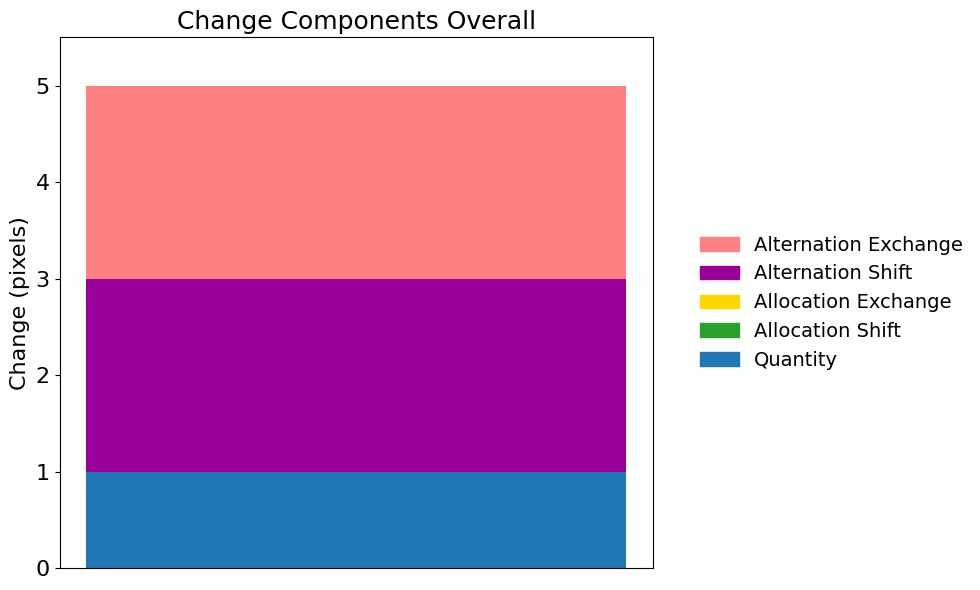

In [15]:
def plot_components_with_alternation(
    csv_path: str,
    output_path: str,
) -> None:
    """
    Plot overall change components as a single stacked bar with controlled y-axis steps.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file containing change components.
    output_path : str
        Directory where the output figure will be saved.
    """
    # 1. Load data
    df = pd.read_csv(
        csv_path,
    )

    # 2. Define Colors and component order
    components_color = {
        "Quantity": "#1f77b4",
        "Allocation_Exchange": "#ffd700",
        "Alternation_Exchange": "#ff8080",
        "Allocation_Shift": "#2ca02c",
        "Alternation_Shift": "#990099",
    }

    component_order = [
        "Quantity",
        "Allocation_Shift",
        "Allocation_Exchange",
        "Alternation_Shift",
        "Alternation_Exchange",
    ]

    # 3. Aggregate totals per component
    component_totals = {
        "Quantity": df[
            (df["Component"] == "Allocation_Quantity")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Exchange": df[
            (df["Component"] == "Allocation_Exchange")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Shift": df[
            (df["Component"] == "Allocation_Shift")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Alternation_Exchange": df[
            (df["Time_Interval"] == "alternation_exchange")
            & (df["Gain"] > 0)
        ]["Gain"].sum(),
        "Alternation_Shift": df[
            (df["Time_Interval"] == "alternation_shift")
        ]["Gain"].sum()
        + df[
            (df["Time_Interval"] == "alternation_exchange")
            & (df["Gain"] < 0)
        ]["Gain"].sum(),
    }

    # 4. Automatic scale based on the sum of all stacked components
    total_change = sum(
        component_totals.values(),
    )

    if total_change >= 1_000_000:
        scale_factor = 1_000_000.0
        y_label = "Change (million pixels)"
    elif total_change >= 1_000:
        scale_factor = 1_000.0
        y_label = "Change (thousand pixels)"
    elif total_change >= 100:
        scale_factor = 100.0
        y_label = "Change (hundred pixels)"
    else:
        scale_factor = 1.0
        y_label = "Change (pixels)"

    # 5. Initialize figure and axis
    fig, ax = plt.subplots(
        figsize=(
            10,
            6,
        ),
    )

    # 6. Plot each component in a stacked bar at a single x-position
    bottom = 0.0
    for component in component_order:
        value = (
            component_totals.get(
                component,
                0.0,
            )
            / scale_factor
        )
        ax.bar(
            x=0,
            height=value,
            bottom=bottom,
            color=components_color[component],
            edgecolor="none",
            width=0.8,
        )
        bottom += value

    # 7. Axes formatting and labels
    ax.set_ylabel(
        y_label,
        fontsize=16,
    )
    ax.set_title(
        "Change Components Overall",
        fontsize=18,
    )
    ax.xaxis.set_visible(
        False,
    )
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=16,
    )

    # 8. Set y-axis limits and major tick locators (Adjusted for steps of 1 or 2)
    y_max_scaled = bottom * 1.1 if bottom > 0 else 1.0
    ax.set_ylim(
        0,
        y_max_scaled,
    )

    # Logic to choose step 1 or 2 based on data magnitude
    if bottom <= 6:
        step_size = 1.0
    else:
        step_size = 2.0

    ax.yaxis.set_major_locator(
        mticker.MultipleLocator(
            step_size,
        ),
    )

    ax.yaxis.set_major_formatter(
        mticker.FormatStrFormatter(
            "%d",
        ),
    )

    # 9. Configure visible spines for the plot frame
    for spine in [
        "top",
        "right",
        "left",
        "bottom",
    ]:
        ax.spines[spine].set_visible(
            True,
        )

    # 10. Define custom legend elements
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Exchange"],
            label="Alternation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Shift"],
            label="Alternation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Exchange"],
            label="Allocation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Shift"],
            label="Allocation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Quantity"],
            label="Quantity",
        ),
    ]

    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.05,
            0.5,
        ),
        fontsize=14,
        frameon=False,
    )

    # 11. Final layout adjustment and export
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_overall.jpeg",
        ),
        bbox_inches="tight",
        format="jpeg",
        dpi=300,
    )
    plt.show()


# 12. Specify paths and execute the plotting function
csv_components_path = os.path.join(
    output_path,
    "change_components.csv",
)

plot_components_with_alternation(
    csv_path=csv_components_path,
    output_path=output_path,
)

##### 6.2.3 Change Componentes by Class

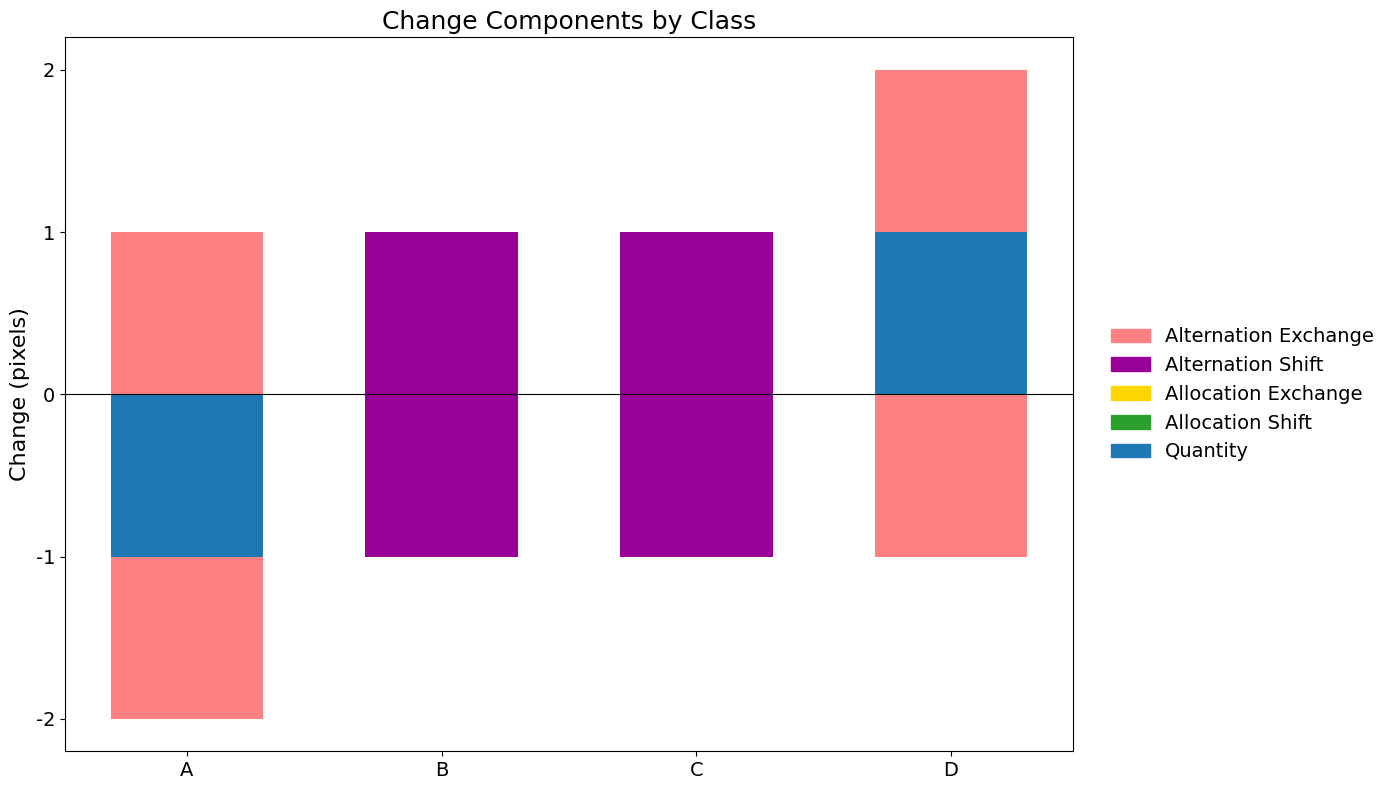

In [16]:
class ComponentVisualizer:
    """
    Visualize change components by class.

    Handles negative correction terms in alternation components correctly.
    """

    @staticmethod
    def plot_gain_loss_stacked(
        df: pd.DataFrame,
        class_labels_dict: dict,
        title: str,
        output_path: str,
    ) -> None:
        """
        Plot per-class gains and losses as stacked bars with auto-scaled y-axis.

        Parameters
        ----------
        df : pd.DataFrame
            DataFrame containing the change components.
        class_labels_dict : dict
            Dictionary mapping class IDs to names/metadata.
        title : str
            Title of the plot.
        output_path : str
            Directory to save the output figure.
        """
        # 1. Filter and Prepare Data
        target_intervals = [
            "extent",
            "alternation_shift",
            "alternation_exchange",
        ]

        # Select rows
        df_sub = df[
            df["Time_Interval"].isin(
                target_intervals,
            )
        ].copy()

        # Rename 'Allocation_Quantity' to 'Quantity' for consistency
        df_sub["Component"] = df_sub["Component"].str.replace(
            "Allocation_Quantity",
            "Quantity",
        )

        # 2. Colors and Order
        components_map = {
            "Quantity": "#1f77b4",
            "Allocation_Exchange": "#ffd700",
            "Alternation_Exchange": "#ff8080",
            "Allocation_Shift": "#2ca02c",
            "Alternation_Shift": "#990099",
        }

        # We process these groups separately to handle the math
        comp_groups = [
            "Quantity",
            "Allocation_Shift",
            "Allocation_Exchange",
        ]

        # 3. Identify Classes and Sort by Net Quantity Change
        classes = sorted(
            df_sub["Class"].unique(),
        )

        # Calculate Net Quantity for Sorting
        class_stats = []
        for cls in classes:
            c_data = df_sub[df_sub["Class"] == cls]
            qty_gain = c_data[c_data["Component"] == "Quantity"]["Gain"].sum()
            qty_loss = c_data[c_data["Component"] == "Quantity"]["Loss"].sum()
            class_stats.append(
                (cls, qty_gain - qty_loss),
            )

        # Sort classes
        ordered_classes = [
            x[0]
            for x in sorted(
                class_stats,
                key=lambda x: x[1],
            )
        ]

        # 4. Prepare Plot Data (Handling the Net Logic)
        plot_data = []  # List of dicts per class
        max_height = 0.0

        for cls in ordered_classes:
            c_data = df_sub[df_sub["Class"] == cls]

            # --- GAINS ---
            # Standard Components
            gains = {}
            for comp in comp_groups:
                gains[comp] = c_data[c_data["Component"] == comp][
                    "Gain"
                ].sum()  # Allocation is usually positive

            # Alternation Logic (Consolidate Exchange + Shift)
            raw_alt_exc = c_data[c_data["Component"] == "Alternation_Exchange"][
                "Gain"
            ].sum()
            raw_alt_shift = c_data[c_data["Component"] == "Alternation_Shift"][
                "Gain"
            ].sum()
            net_alt = raw_alt_exc + raw_alt_shift

            # If Net Alternation is effectively 0, plot neither.
            # If positive, attribute to Exchange first if valid, else Shift.
            adj_alt_exc = 0.0
            adj_alt_shift = 0.0

            if net_alt > 0.0001:
                # If raw exchange is positive (like Class D), keep it
                if raw_alt_exc > 0:
                    adj_alt_exc = raw_alt_exc
                    adj_alt_shift = max(
                        0,
                        net_alt - raw_alt_exc,
                    )
                else:
                    # If raw exchange is negative (Class A correction), hide it inside Shift
                    adj_alt_exc = 0
                    adj_alt_shift = net_alt

            gains["Alternation_Exchange"] = adj_alt_exc
            gains["Alternation_Shift"] = adj_alt_shift

            # --- LOSSES (Logic is identical but using Loss column) ---
            losses = {}
            for comp in comp_groups:
                losses[comp] = c_data[c_data["Component"] == comp]["Loss"].sum()

            raw_alt_exc_l = c_data[c_data["Component"] == "Alternation_Exchange"][
                "Loss"
            ].sum()
            raw_alt_shift_l = c_data[c_data["Component"] == "Alternation_Shift"][
                "Loss"
            ].sum()
            net_alt_l = raw_alt_exc_l + raw_alt_shift_l

            adj_alt_exc_l = 0.0
            adj_alt_shift_l = 0.0

            if net_alt_l > 0.0001:
                if raw_alt_exc_l > 0:
                    adj_alt_exc_l = raw_alt_exc_l
                    adj_alt_shift_l = max(
                        0,
                        net_alt_l - raw_alt_exc_l,
                    )
                else:
                    adj_alt_exc_l = 0
                    adj_alt_shift_l = net_alt_l

            losses["Alternation_Exchange"] = adj_alt_exc_l
            losses["Alternation_Shift"] = adj_alt_shift_l

            # Track max height for scaling
            total_g = sum(
                gains.values(),
            )
            total_l = sum(
                losses.values(),
            )
            max_height = max(
                max_height,
                total_g,
                total_l,
            )

            plot_data.append(
                {
                    "class": cls,
                    "gains": gains,
                    "losses": losses,
                },
            )

        # 5. Determine Scale Factor
        if max_height >= 1_000_000:
            scale_factor = 1_000_000.0
            y_label = "Change (million pixels)"
        elif max_height >= 1_000:
            scale_factor = 1_000.0
            y_label = "Change (thousand pixels)"
        elif max_height >= 100:
            scale_factor = 100.0
            y_label = "Change (hundred pixels)"
        else:
            scale_factor = 1.0
            y_label = "Change (pixels)"

        # 6. Plotting
        fig, ax = plt.subplots(
            figsize=(
                14,
                8,
            ),
        )
        fig.subplots_adjust(
            left=0.1,
            right=0.75,
        )

        x_pos = np.arange(
            len(ordered_classes),
        )
        width = 0.6

        # Order for stacking: Quantity at bottom, then Alloc, then Alt
        stack_order = [
            "Quantity",
            "Allocation_Shift",
            "Allocation_Exchange",
            "Alternation_Shift",
            "Alternation_Exchange",
        ]

        for idx, item in enumerate(
            plot_data,
        ):
            # Gains (Upwards)
            bottom_g = 0.0
            for comp in stack_order:
                val = item["gains"][comp] / scale_factor
                if val > 0:
                    ax.bar(
                        x_pos[idx],
                        val,
                        width,
                        bottom=bottom_g,
                        color=components_map[comp],
                        edgecolor="none",
                    )
                    bottom_g += val

            # Losses (Downwards)
            bottom_l = 0.0
            for comp in stack_order:
                val = item["losses"][comp] / scale_factor
                if val > 0:
                    ax.bar(
                        x_pos[idx],
                        -val,
                        width,
                        bottom=bottom_l,
                        color=components_map[comp],
                        edgecolor="none",
                    )
                    bottom_l -= val

        # 7. Formatting
        class_names = [
            class_labels_dict.get(
                int(c) if str(c).isdigit() else c,
                {},
            )
            .get(
                "name",
                str(c),
            )
            .replace(
                "Class",
                "",
            )
            .strip()
            for c in ordered_classes
        ]

        ax.set_xticks(
            x_pos,
        )
        ax.set_xticklabels(
            class_names,
            rotation=0,
            ha="center",
            fontsize=14,
        )
        ax.axhline(
            0,
            color="black",
            linewidth=0.8,
        )

        ax.set_ylabel(
            y_label,
            fontsize=16,
        )
        ax.set_title(
            title,
            fontsize=18,
        )
        ax.tick_params(
            axis="both",
            labelsize=14,
        )

        # Y-Axis Limits and Integer Ticks
        limit = max_height / scale_factor * 1.1 if max_height > 0 else 1.0
        ax.set_ylim(
            -limit,
            limit,
        )
        ax.yaxis.set_major_locator(
            mticker.MaxNLocator(
                integer=True,
                nbins=6,
            ),
        )
        ax.yaxis.set_major_formatter(
            mticker.FormatStrFormatter(
                "%d",
            ),
        )

        # Legend
        handles = [
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_map[c],
                label=c.replace("_", " "),
            )
            for c in reversed(stack_order)  # Top to bottom order in legend
        ]

        ax.legend(
            handles=handles,
            loc="center left",
            bbox_to_anchor=(
                1.02,
                0.5,
            ),
            fontsize=14,
            frameon=False,
        )

        plt.tight_layout()
        plt.savefig(
            os.path.join(
                output_path,
                "graphic_change_component_change_class.jpeg",
            ),
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()


# 8. Load Data and Execute
csv_components_path = os.path.join(
    output_path,
    "change_components.csv",
)
df_components = pd.read_csv(
    csv_components_path,
)

ComponentVisualizer.plot_gain_loss_stacked(
    df=df_components,
    class_labels_dict=class_labels_dict,
    title="Change Components by Class",
    output_path=output_path,
)

## **7. Number of Changes**

### 7.1 Compute Number of Changes

In [17]:
def number_of_changes_raster(
    input_dir: str,
    output_dir: str,
    nodata_val: int,
) -> None:
    """
    Compute and save a raster representing the total number of class changes per pixel.

    Parameters
    ----------
    input_dir : str
        Directory containing the input raster images.
    output_dir : str
        Directory to save the output raster.
    nodata_val : int
        Value representing NoData pixels to be ignored in comparisons.
    """
    # 1. Search for raster files inside the directory
    # Using the same logic as the first cell to ensure consistency
    search_pattern = os.path.join(
        input_dir,
        "*.tif",
    )
    image_paths = sorted(
        glob.glob(
            search_pattern,
        ),
    )

    if len(image_paths) < 2:
        raise ValueError(
            f"At least two images are required to compute changes. Found {len(image_paths)} in {input_dir}",
        )

    # 2. Initialize using the first image
    with rasterio.open(
        image_paths[0],
    ) as src:
        profile = src.profile
        shape = src.shape
        data_prev = src.read(
            1,
        )

    # Accumulator for changes
    total_changes = np.zeros(
        shape,
        dtype=np.uint16,
    )

    print(
        f"Computing number of changes across {len(image_paths)} raster maps...",
    )

    # 3. Iterate through consecutive pairs
    for i in range(
        1,
        len(image_paths),
    ):
        with rasterio.open(
            image_paths[i],
        ) as src:
            data_curr = src.read(
                1,
            )

        # 4. Calculate change: Values differ AND neither is NoData
        change_mask = (
            (data_prev != data_curr)
            & (data_prev != nodata_val)
            & (data_curr != nodata_val)
        )

        total_changes += change_mask.astype(
            np.uint16,
        )

        # Update previous for next iteration
        data_prev = data_curr

    # 5. Save the Output Raster
    out_raster_path = os.path.join(
        output_dir,
        "number_of_changes.tif",
    )

    # Update profile for the output count raster
    profile.update(
        dtype=rasterio.uint16,
        count=1,
        nodata=None,
        compress="lzw",
    )

    with rasterio.open(
        out_raster_path,
        "w",
        **profile,
    ) as dst:
        dst.write(
            total_changes,
            1,
        )

    print(
        f"Number of changes raster saved to: {out_raster_path}",
    )


# Execute the function using input_paths (which is the directory string)
number_of_changes_raster(
    input_dir=input_paths,
    output_dir=output_path,
    nodata_val=noData_value,
)

Computing number of changes across 6 raster maps...
Number of changes raster saved to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/number_of_changes.tif


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


### 7.2 Plot Number of Changes Map

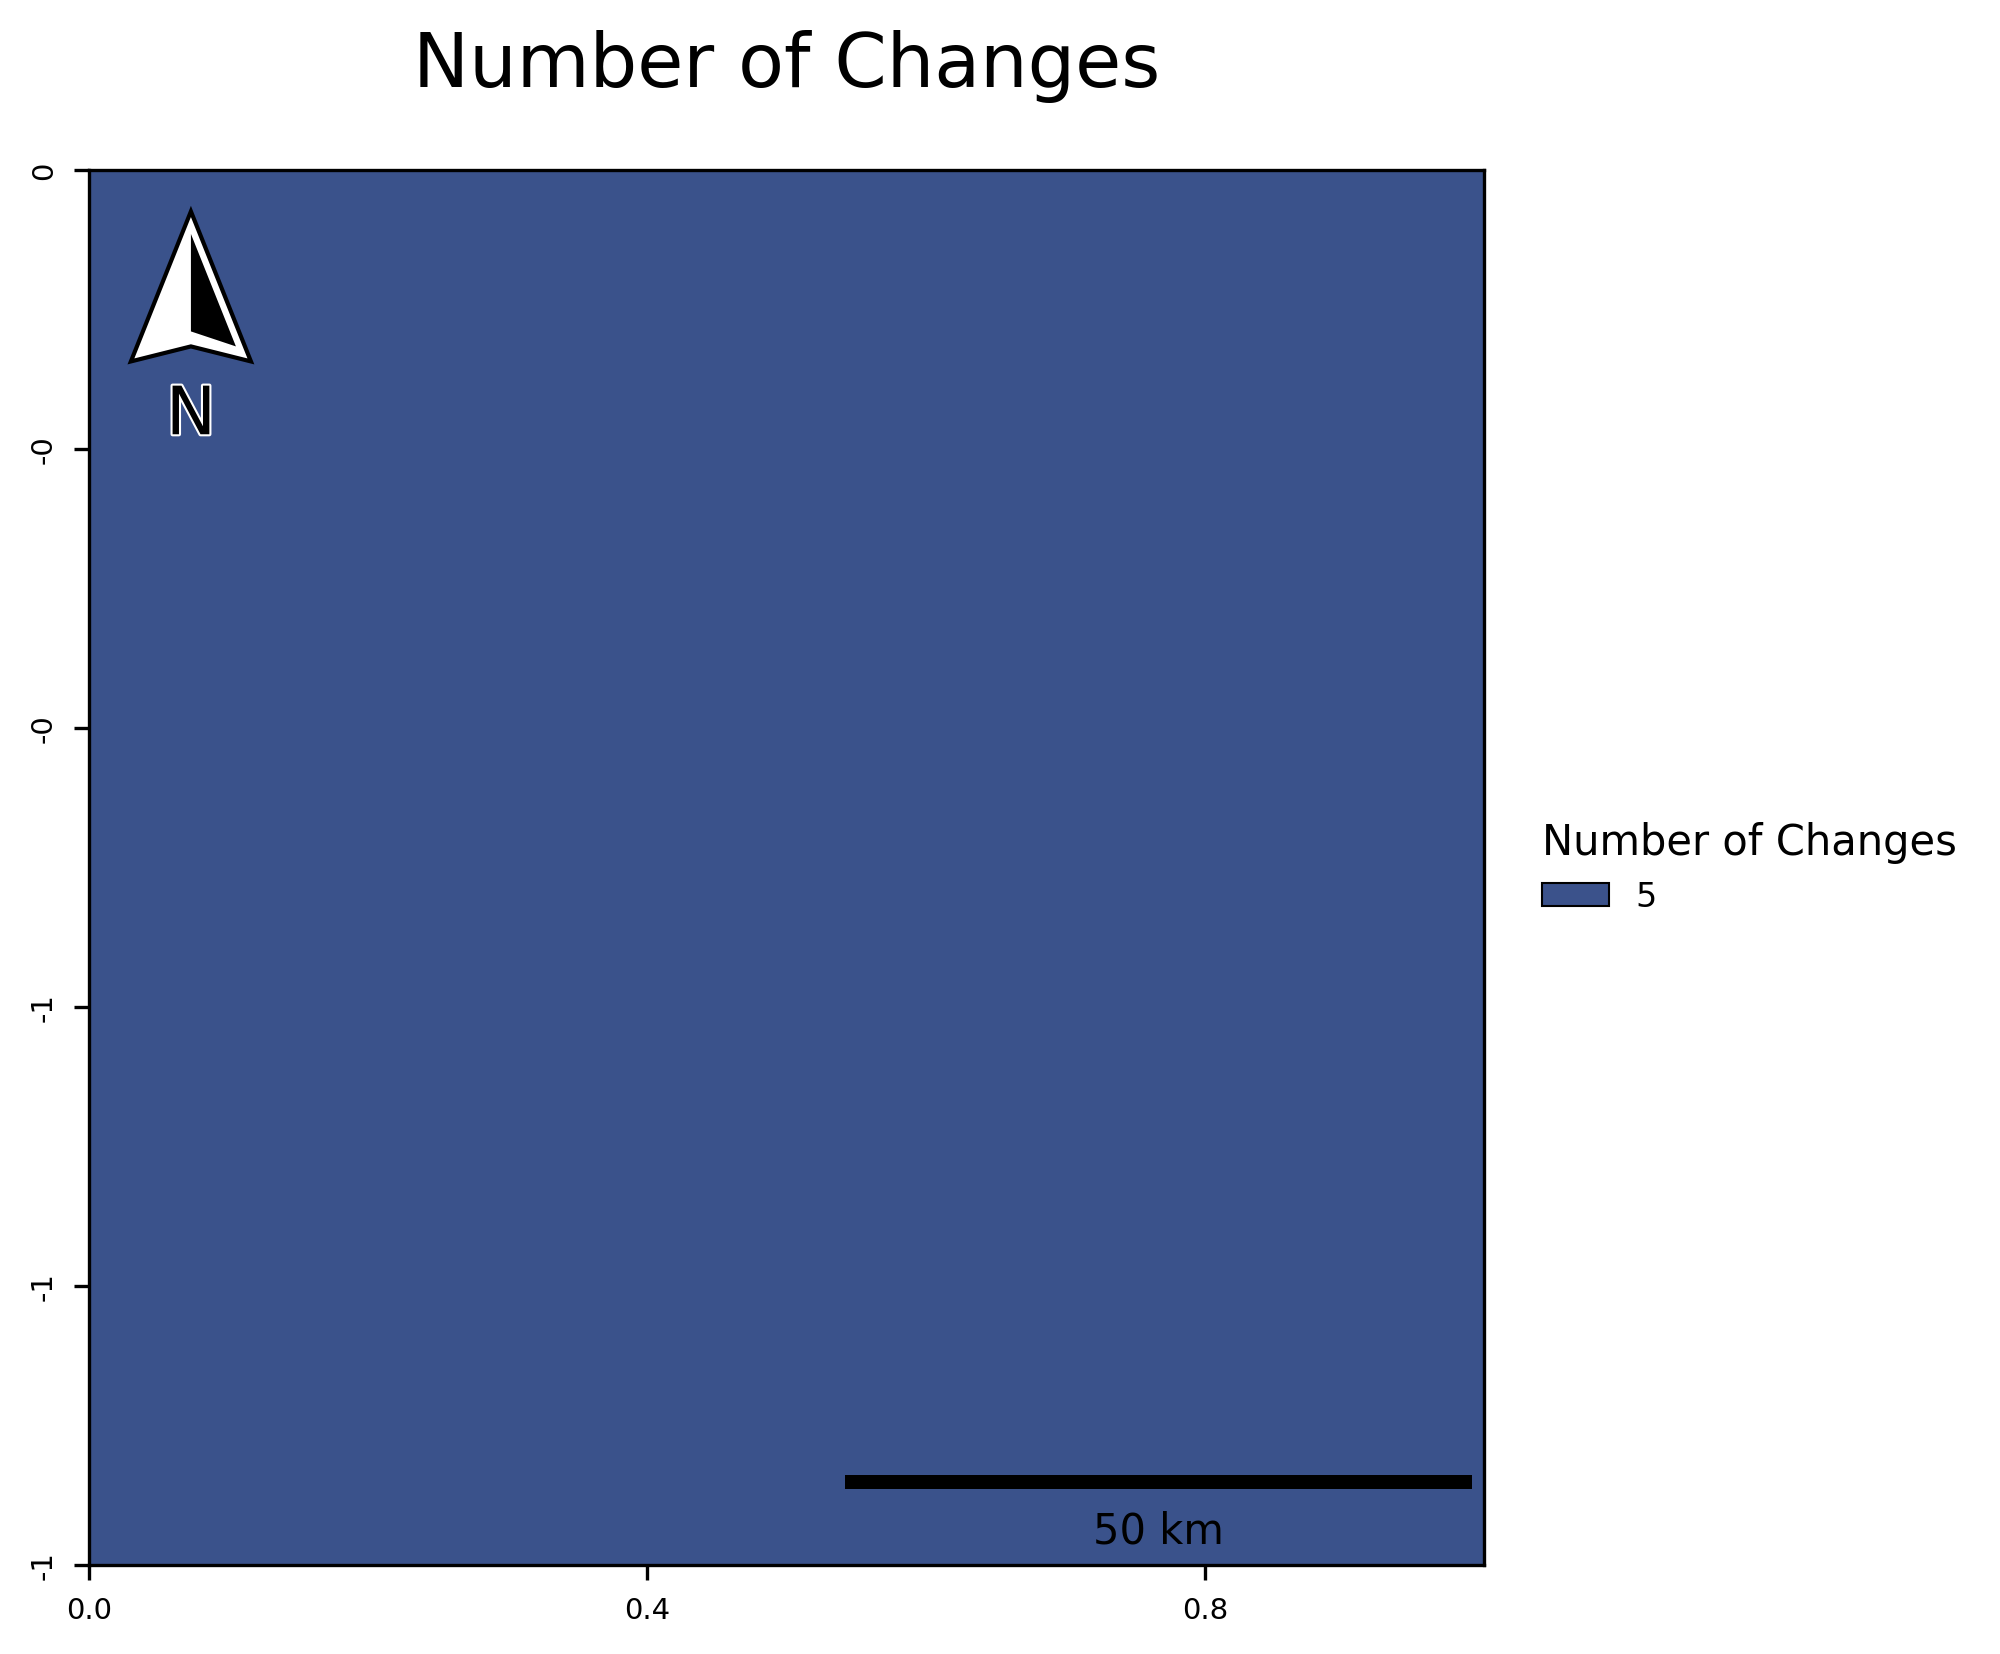

Map figure saved successfully to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_number_of_changes.png


In [18]:
def plot_number_of_changes_map(
    output_dir: str,
    raster_filename: str = "number_of_changes.tif",
) -> None:
    """
    Plot the Number of Changes raster map with cartographic elements.

    Parameters
    ----------
    output_dir : str
        Directory containing the raster file and where the map will be saved.
    raster_filename : str, optional
        Name of the raster file to plot (default is "number_of_changes.tif").
    """
    # 1) Input raster path
    raster_to_plot_path = os.path.join(
        output_dir,
        raster_filename,
    )

    if not os.path.exists(raster_to_plot_path):
        raise FileNotFoundError(
            f"Raster not found: {raster_to_plot_path}",
        )

    # 2) Read raster and basic metadata
    with rasterio.open(
        raster_to_plot_path,
    ) as src:
        scale_factor = 1

        data = src.read(
            1,
            out_shape=(
                int(src.height * scale_factor),
                int(src.width * scale_factor),
            ),
            resampling=rasterio.enums.Resampling.nearest,
        )

        nodata_value = src.nodata
        if nodata_value is not None:
            data = np.ma.masked_equal(
                data,
                nodata_value,
            )

        left, bottom, right, top = src.bounds
        src_crs = src.crs
        transform = src.transform

    # 3) Figure
    fig, ax = plt.subplots(
        figsize=(
            6,
            8,
        ),
        dpi=300,
    )

    # Data range
    min_val = int(
        np.ma.min(
            data,
        ),
    )
    max_val = int(
        np.ma.max(
            data,
        ),
    )

    # 4) Colormap (gray for 0 + jet for 1..max)
    original_cmap = plt.get_cmap(
        "viridis",
    )
    color_list = [
        "#c0c0c0",
    ] + [
        original_cmap(i)
        for i in np.linspace(
            0,
            1,
            max_val,
        )
    ]
    cmap = ListedColormap(
        color_list,
    )

    # Discrete normalization
    bounds = np.arange(
        min_val,
        max_val + 2,
    ) - 0.5
    norm = BoundaryNorm(
        bounds,
        cmap.N,
    )

    # 5) Plot raster in original projection coordinates
    ax.imshow(
        data,
        extent=[
            left,
            right,
            bottom,
            top,
        ],
        cmap=cmap,
        interpolation="none",
        norm=norm,
    )

    # 6) Discrete box legend
    legend_elements = []
    for i in range(
        min_val,
        max_val + 1,
    ):
        legend_elements.append(
            Patch(
                facecolor=cmap(
                    norm(i),
                ),
                edgecolor="black",
                linewidth=0.5,
                label=str(i),
            ),
        )

    ax.legend(
        handles=legend_elements,
        title="Number of Changes",
        loc="center left",
        bbox_to_anchor=(
            1.02,
            0.5,
        ),
        frameon=False,
        fontsize=8,
        title_fontsize=10,
        alignment="left",
    )

    # 7) Cartographic elements (scale bar + north arrow)
    # Compute approximate pixel size in meters for any CRS
    if src_crs is not None and src_crs.is_projected:
        pixel_size_m = transform.a
    else:
        # Assuming Geod, CRS, and Transformer are imported globally
        geod = Geod(
            ellps="WGS84",
        )
        crs_ll = CRS.from_epsg(
            4326,
        )

        if src_crs is not None and src_crs.to_string() != crs_ll.to_string():
            transformer_ll = Transformer.from_crs(
                src_crs,
                crs_ll,
                always_xy=True,
            )
        else:
            transformer_ll = None

        x_center = (left + right) / 2.0
        y_center = (bottom + top) / 2.0

        if transformer_ll is not None:
            lon_center, lat_center = transformer_ll.transform(
                x_center,
                y_center,
            )
            lon_right, _ = transformer_ll.transform(
                x_center + transform.a,
                y_center,
            )
        else:
            lon_center, lat_center = x_center, y_center
            lon_right = x_center + transform.a

        _, _, dist_m = geod.inv(
            lon_center,
            lat_center,
            lon_right,
            lat_center,
        )
        pixel_size_m = dist_m

    scalebar = ScaleBar(
        dx=pixel_size_m / 1000.0,
        units="km",
        length_fraction=0.5,
        location="lower right",
        box_alpha=0.0,
        scale_formatter=lambda value, _: f"{int(value)} km",
    )
    ax.add_artist(
        scalebar,
    )

    north_arrow(
        ax,
        location="upper left",
        shadow=False,
        rotation={
            "degrees": 0,
        },
    )

    # 8) Axes styling
    ax.set_title(
        "Number of Changes",
        fontsize=18,
        pad=20,
    )
    ax.set_aspect(
        "equal",
    )
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        pad=4,
    )
    ax.xaxis.set_major_locator(
        mticker.MaxNLocator(
            3,
        ),
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            6,
        ),
    )

    # Show y-axis coordinates on the left, vertically
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(
            lambda y, pos: f"{y:.0f}",
        ),
    )
    plt.setp(
        ax.get_yticklabels(),
        rotation=90,
        va="center",
    )

    # 9) Save
    output_figure_path = os.path.join(
        output_dir,
        "map_number_of_changes.png",
    )
    plt.savefig(
        output_figure_path,
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.5,
    )
    plt.show()

    print(
        f"Map figure saved successfully to: {output_figure_path}",
    )


# Execute the function
plot_number_of_changes_map(
    output_dir=output_path,
)

## **8. Trajectory Classification**


---
This section provides a framework for processing and classifying pixel trajectories in raster datasets.


### 8.1 Compute Trajectory Analysis
This section processes and visualizes raster data by scaling, applying a color map, and adding graphical elements like legends, scale bars, and north arrows. The output is a high-resolution image of the classified raster data.

In [19]:
@nb.njit(
    nogil=True,
)
def classify_pixel(
    pixel_series: np.ndarray,
    nodata_val: int,
) -> np.uint8:
    """
    Classify a single pixel trajectory into four categories based on temporal changes.

    Parameters
    ----------
    pixel_series : np.ndarray
        A 1D numpy array representing the land cover class values
        of a single pixel over time.

    Returns
    -------
    np.uint8
        An integer representing the trajectory class:
        0: NoData (Background)
        1: Stable (No change)
        2: Alternation (Change occurs, but Start Class == End Class)
        3: Step (Start != End, and a direct transition exists)
        4: Complex (Start != End, and no direct transition exists)
    """
    if pixel_series[0] == nodata_val:
        return np.uint8(
            0,
        )

    start = pixel_series[
        0
    ]
    end = pixel_series[
        -1
    ]

    has_variation = False
    direct_transition = False

    for i in range(
        len(
            pixel_series,
        )
        - 1,
    ):
        current = pixel_series[
            i
        ]
        next_val = pixel_series[
            i + 1
        ]

        if current == nodata_val or next_val == nodata_val:
            return np.uint8(nodata_val)

        if current != next_val:
            has_variation = True
            if (current == start) and (next_val == end):
                direct_transition = True

    if not has_variation:
        return np.uint8(
            1,
        )

    if start == end:
        return np.uint8(
            2,
        )

    if direct_transition:
        return np.uint8(
            3,
        )

    return np.uint8(
        4,
    )


@nb.njit(
    nogil=True,
    parallel=True,
)
def process_stack_parallel(
    stack: np.ndarray,
    height: int,
    width: int,
    nodata_val: int,
) -> np.ndarray:
    """
    Apply pixel classification to a 3D raster stack using parallel processing.

    Parameters
    ----------
    stack : np.ndarray
        A 3D numpy array of shape (time, height, width) containing
        the stacked raster data.
    height : int
        The height (number of rows) of the spatial grid.
    width : int
        The width (number of columns) of the spatial grid.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (height, width) containing the
        classified trajectory codes (uint8).
    """
    result = np.zeros(
        (
            height,
            width,
        ),
        dtype=np.uint8,
    )

    result[:] = nodata_val

    for y in prange(
        height,
    ):
        for x in range(
            width,
        ):
            result[
                y,
                x,
            ] = classify_pixel(
                stack[
                    :,
                    y,
                    x,
                ],
                nodata_val
            )
    return result


def generate_trajectory_raster(
    input_dir: str,
    output_dir: str,
) -> str:
    """
    Load time-series rasters from directory, classify trajectories, and save the result.

    Parameters
    ----------
    input_dir : str
        The directory path containing input rasters.
    output_dir : str
        The directory path where the output file will be saved.

    Returns
    -------
    str
        The full file path to the generated trajectory raster.

    Raises
    ------
    ValueError
        If no images are found in the directory.
    """
    # 1. Search for raster files inside the directory
    search_pattern = os.path.join(
        input_dir,
        "*.tif",
    )
    image_paths = sorted(
        glob.glob(
            search_pattern,
        ),
    )

    if not image_paths:
        raise ValueError(
            f"No rasters found in {input_dir}",
        )

    print(
        f"Starting trajectory analysis on {len(image_paths)} rasters...",
    )

    # Read metadata from the first image
    with rasterio.open(
        image_paths[0],
    ) as src:
        meta = src.meta.copy()
        height = src.height
        width = src.width
        current_nodata = int(noData_value)

    # Load all rasters into a list
    stack_list = []
    for p in tqdm(
        image_paths,
        desc="Loading rasters",
    ):
        with rasterio.open(
            p,
        ) as src:
            stack_list.append(
                src.read(
                    1,
                ),
            )

    # Convert to 3D numpy array
    stack = np.array(
        stack_list,
    )

    print(
        "Classifying trajectories...",
    )

    # Apply Numba-accelerated classification
    trajectory_map = process_stack_parallel(
        stack,
        height,
        width,
        current_nodata,
    )

    # Update metadata
    meta.update(
        dtype=np.uint8,
        count=1,
        nodata=current_nodata,
    )

    out_file = os.path.join(
        output_dir,
        "trajectory.tif",
    )

    with rasterio.open(
        out_file,
        "w",
        **meta,
    ) as dst:
        dst.write(
            trajectory_map,
            1,
        )

    print(
        f"Trajectory map saved successfully to: {out_file}",
    )

    return out_file


# Execute trajectory analysis
# Passing input_paths (string) as input_dir
trajectory_file = generate_trajectory_raster(
    input_dir=input_paths,
    output_dir=output_path,
)

Starting trajectory analysis on 6 rasters...


Loading rasters: 100%|██████████| 6/6 [00:00<00:00, 144.91it/s]

Classifying trajectories...


Trajectory map saved successfully to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/trajectory.tif


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


### 8.2 Plot Trajectory Analysis Graphic

Unique values in raster: [3]
Computed Percentages: {2: 0.0, 3: 100.0, 4: 0.0}


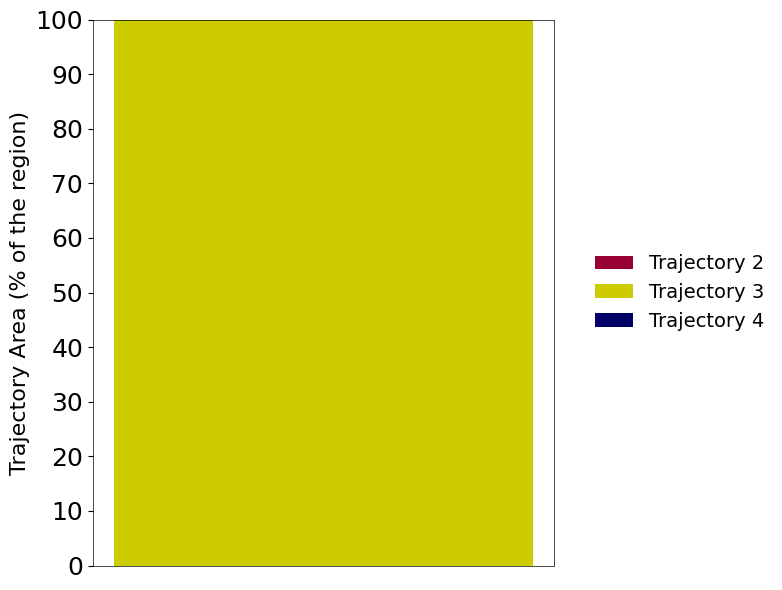

In [20]:
def plot_trajectory_distribution(
    output_path: str,
) -> None:
    """
    Plot a stacked bar with the distribution of trajectory classes.

    Parameters
    ----------
    output_path : str
        Directory containing the 'trajectory.tif' raster.
    """
    raster_path = os.path.join(
        output_path,
        "trajectory.tif",
    )

    with rasterio.open(
        raster_path,
    ) as src:
        traj_data = src.read(
            1,
        )
        nodata = src.nodata

    masked_traj = np.ma.masked_where(
        traj_data == nodata,
        traj_data,
    )

    unique_vals, counts = np.unique(
        masked_traj.compressed(),
        return_counts=True,
    )

    data_counts = dict(
        zip(
            unique_vals,
            counts,
        ),
    )

    total_pixels = sum(
        data_counts.values(),
    )

    print(
        f"Unique values in raster: {unique_vals}",
    )

    # Convert to native python float to avoid 'np.float64' in print
    percentages = {
        i: float(
            (
                data_counts.get(
                    i,
                    0,
                )
                / total_pixels
            )
            * 100.0
        )
        for i in [
            2,
            3,
            4,
        ]
    }

    print(
        f"Computed Percentages: {percentages}",
    )

    ordered_trajs = [
        4,
        3,
        2,
    ]
    colors = {
        4: "#000066",  # Dark Blue
        3: "#cccc00",  # Yellow
        2: "#990033",  # Dark Red
    }

    fig, ax = plt.subplots(
        figsize=(
            8,
            6,
        ),
    )

    bottom = 0.0
    for traj in ordered_trajs:
        val = percentages[
            traj
        ]
        ax.bar(
            0,
            val,
            bottom=bottom,
            color=colors[
                traj
            ],
            width=0.4,
            edgecolor="none",
        )
        bottom += val

    ax.set_ylabel(
        "Trajectory Area (% of the region)",
        fontsize=16,
    )

    for spine in [
        "top",
        "right",
        "bottom",
        "left",
    ]:
        ax.spines[
            spine
        ].set_visible(
            True,
        )
        ax.spines[
            spine
        ].set_color(
            "black",
        )
        ax.spines[
            spine
        ].set_linewidth(
            0.5,
        )

    ax.tick_params(
        axis="y",
        which="major",
        labelsize=18,
    )

    # Remove x-axis ticks to leave it blank
    ax.set_xticks(
        [],
    )

    ax.set_ylim(
        0,
        100,
    )

    # Use mticker for consistency
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            integer=True,
        ),
    )
    ax.yaxis.set_major_formatter(
        mticker.FormatStrFormatter(
            "%d",
        ),
    )

    # Legend with Original Names
    legend_elements = [
        Patch(
            facecolor=colors[
                2
            ],
            label="Trajectory 2",
        ),
        Patch(
            facecolor=colors[
                3
            ],
            label="Trajectory 3",
        ),
        Patch(
            facecolor=colors[
                4
            ],
            label="Trajectory 4",
        ),
    ]

    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.05,
            0.5,
        ),
        fontsize=14,
        frameon=False,
    )

    plt.tight_layout()

    # Save the figure
    out_fig_path = os.path.join(
        output_path,
        "graphic_trajectory_distribution.jpeg",
    )
    plt.savefig(
        out_fig_path,
        dpi=300,
        bbox_inches="tight",
        format="jpeg",
    )
    plt.show()


# Execution
plot_trajectory_distribution(
    output_path=output_path,
)

### 8.3 Plot Trajectory Analysis Map

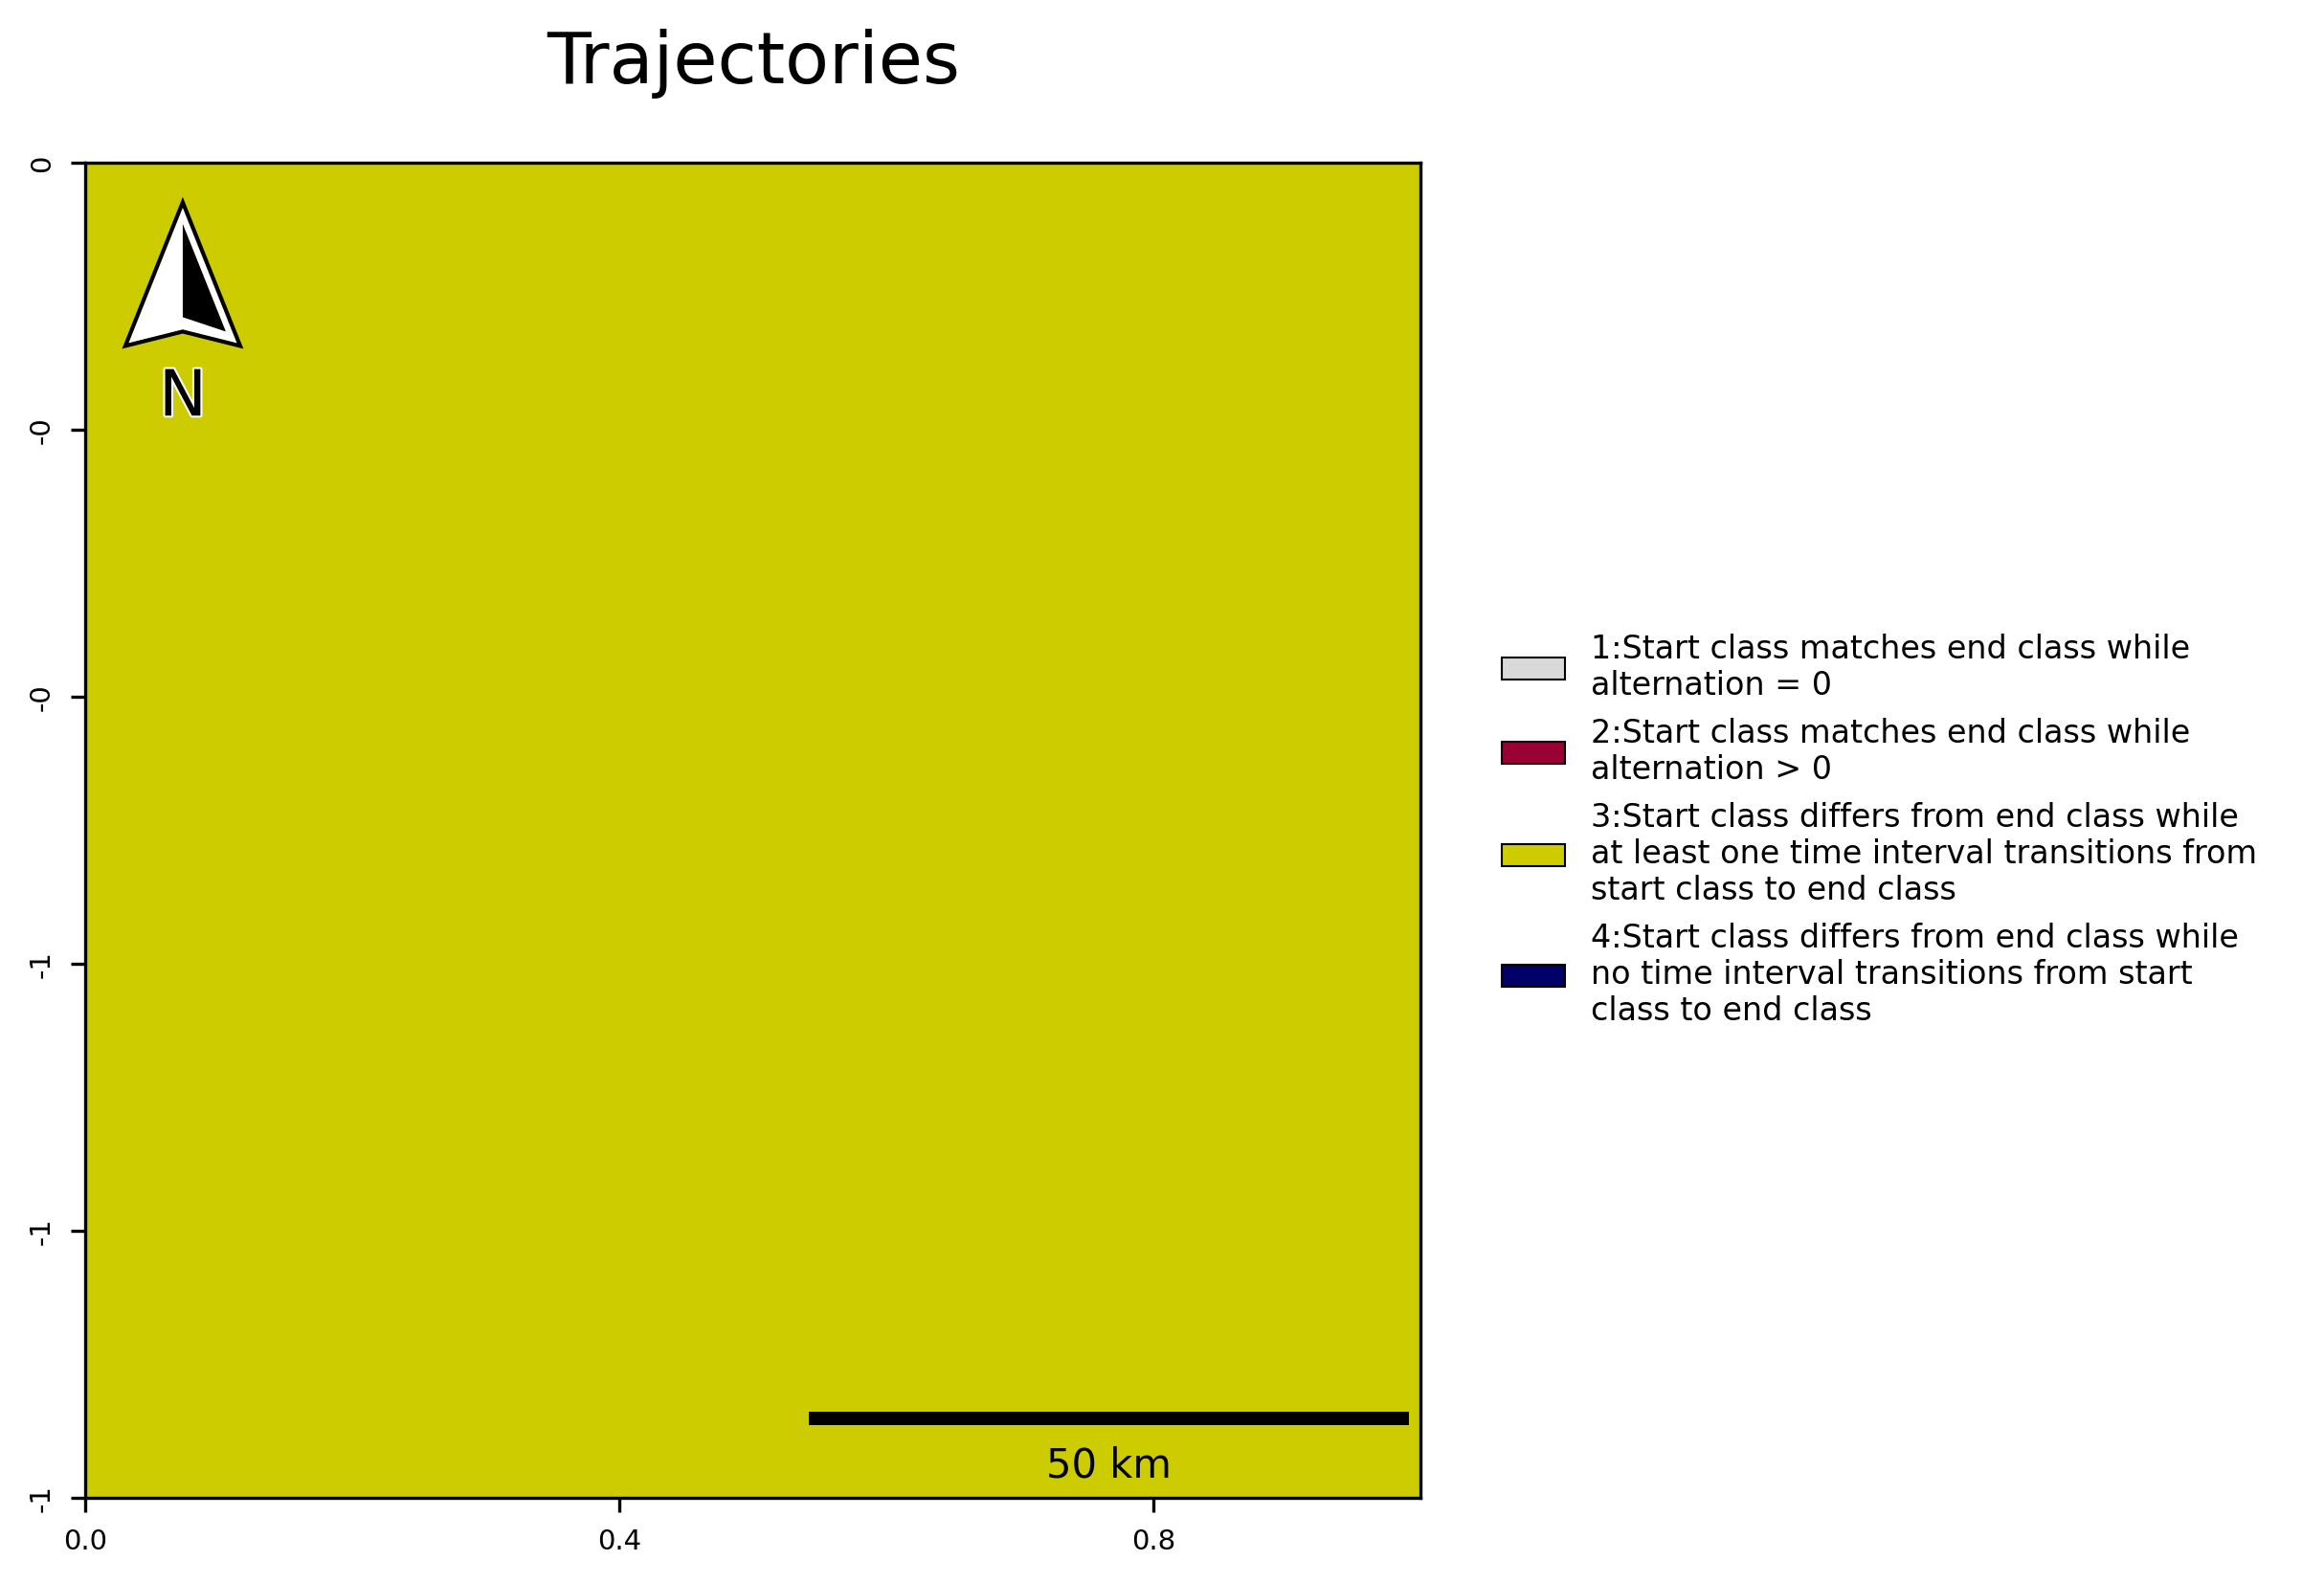

Trajectory map saved successfully to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_trajectories.png


In [21]:
def plot_trajectory_map(
    output_dir: str,
    raster_filename: str = "trajectory.tif",
) -> None:
    """
    Plot the Trajectory raster map with specific categorical coloring and full descriptions.

    Parameters
    ----------
    output_dir : str
        Directory containing the raster file and where the map will be saved.
    raster_filename : str, optional
        Name of the raster file to plot (default is "trajectory.tif").
    """
    # 1) Input raster path
    raster_path = os.path.join(
        output_dir,
        raster_filename,
    )

    if not os.path.exists(raster_path):
        raise FileNotFoundError(
            f"Raster not found: {raster_path}",
        )

    # 2) Read raster and basic metadata
    with rasterio.open(
        raster_path,
    ) as src:
        scale_factor = 1

        data = src.read(
            1,
            out_shape=(
                int(src.height * scale_factor),
                int(src.width * scale_factor),
            ),
            resampling=rasterio.enums.Resampling.nearest,
        )

        nodata_val = src.nodata
        if nodata_val is not None:
             data = np.ma.masked_equal(data, nodata_val)

        left, bottom, right, top = src.bounds
        src_crs = src.crs
        transform = src.transform

    # 3) Figure
    fig, ax = plt.subplots(
        figsize=(
            6,
            8,
        ),
        dpi=300,
    )

    # 4) Colormap (categorical: 1–4)
    cmap = ListedColormap(
        [
            "#d9d9d9",  # 1
            "#990033",  # 2
            "#cccc00",  # 3
            "#000066",  # 4
        ],
    )
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = BoundaryNorm(bounds, cmap.N)

    # 5) Plot raster in original projection coordinates
    ax.imshow(
        data,
        extent=[
            left,
            right,
            bottom,
            top,
        ],
        cmap=cmap,
        norm=norm,
        interpolation="nearest"
    )

    # 6) Legend
    # Using Patch for consistency, preserving original text
    legend_elements = [
        Patch(
            facecolor="#d9d9d9",
            label=(
                "1:Start class matches end class while\n"
                "alternation = 0"
            ),
            edgecolor="black",
            linewidth=0.5,
        ),
        Patch(
            facecolor="#990033",
            label=(
                "2:Start class matches end class while\n"
                "alternation > 0"
            ),
            edgecolor="black",
            linewidth=0.5,
        ),
        Patch(
            facecolor="#cccc00",
            label=(
                "3:Start class differs from end class while\n"
                "at least one time interval transitions from\n"
                "start class to end class"
            ),
            edgecolor="black",
            linewidth=0.5,
        ),
        Patch(
            facecolor="#000066",
            label=(
                "4:Start class differs from end class while\n"
                "no time interval transitions from start\n"
                "class to end class"
            ),
            edgecolor="black",
            linewidth=0.5,
        ),
    ]

    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.02,
            0.5,
        ),
        frameon=False,
        fontsize=8,
        borderpad=1.2,
        handletextpad=0.8,
        columnspacing=2,
    )

    # 7) Cartographic elements (scale bar + north arrow)
    # Compute approximate pixel size in meters for any CRS
    if src_crs is not None and src_crs.is_projected:
        pixel_size_m = transform.a
    else:
        # Assuming Geod, CRS, and Transformer are imported globally
        geod = Geod(
            ellps="WGS84",
        )
        crs_ll = CRS.from_epsg(
            4326,
        )

        if src_crs is not None and src_crs.to_string() != crs_ll.to_string():
            transformer_ll = Transformer.from_crs(
                src_crs,
                crs_ll,
                always_xy=True,
            )
        else:
            transformer_ll = None

        x_center = (left + right) / 2.0
        y_center = (bottom + top) / 2.0

        if transformer_ll is not None:
            lon_center, lat_center = transformer_ll.transform(
                x_center,
                y_center,
            )
            lon_right, _ = transformer_ll.transform(
                x_center + transform.a,
                y_center,
            )
        else:
            lon_center, lat_center = x_center, y_center
            lon_right = x_center + transform.a

        _, _, dist_m = geod.inv(
            lon_center,
            lat_center,
            lon_right,
            lat_center,
        )
        pixel_size_m = dist_m

    scalebar = ScaleBar(
        dx=pixel_size_m / 1000.0,
        units="km",
        length_fraction=0.5,
        location="lower right",
        box_alpha=0.0,
        scale_formatter=lambda value, _: f"{int(value)} km",
    )
    ax.add_artist(
        scalebar,
    )

    north_arrow(
        ax,
        location="upper left",
        shadow=False,
        rotation={
            "degrees": 0,
        },
    )

    # 8) Axes styling
    ax.set_title(
        "Trajectories",
        fontsize=18,
        pad=20,
    )
    ax.set_aspect(
        "equal",
    )
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        pad=4,
    )
    ax.xaxis.set_major_locator(
        mticker.MaxNLocator(
            3,
        ),
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            6,
        ),
    )

    # Show y-axis coordinates on the left, vertically
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(
            lambda y, pos: f"{y:.0f}",
        ),
    )
    plt.setp(
        ax.get_yticklabels(),
        rotation=90,
        va="center",
    )

    # 9) Save
    output_figure_path = os.path.join(
        output_dir,
        "map_trajectories.png",
    )
    plt.savefig(
        output_figure_path,
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.5,
    )
    plt.show()

    print(
        f"Trajectory map saved successfully to: {output_figure_path}",
    )


# Execute the function
plot_trajectory_map(
    output_dir=output_path,
)

### **8.4 Trajectory contributions per Time Interval**

In [22]:
@nb.njit(
    nogil=True,
    fastmath=True,
)
def compute_trajectory_changes_numba(
    trajectory_map: np.ndarray,
    stack: np.ndarray,
    nodata: int,
) -> np.ndarray:
    """
    Count pixels per trajectory type changing in each time interval using Numba.

    Parameters
    ----------
    trajectory_map : np.ndarray
        2D array (height, width) with trajectory IDs (2, 3, 4).
    stack : np.ndarray
        3D array (time, height, width) with pixel values.
    nodata : int
        Value to ignore.

    Returns
    -------
    np.ndarray
        2D array of shape (n_intervals, 5) containing change counts.
        Rows correspond to time intervals.
        Columns correspond to trajectory IDs (0 to 4).
    """
    n_times = stack.shape[0]
    height = stack.shape[1]
    width = stack.shape[2]
    n_intervals = n_times - 1

    # Array to store counts: rows=intervals, cols=trajectory_ids(0-4)
    # We use 5 columns to map the trajectory ID directly as an index
    counts = np.zeros(
        (
            n_intervals,
            5,
        ),
        dtype=np.int64,
    )

    # Iterate over every pixel
    # Note: We use serial execution (range, not prange) here to avoid
    # race conditions on the 'counts' array updates. Numba is fast enough
    # that serial execution is still seconds vs minutes compared to Python.
    for y in range(
        height,
    ):
        for x in range(
            width,
        ):
            traj_id = trajectory_map[
                y,
                x,
            ]

            # We only care about Alternation(2), Step(3), Complex(4)
            if traj_id < 2 or traj_id > 4:
                continue

            # Check changes across all time intervals
            for t in range(
                n_intervals,
            ):
                val_from = stack[
                    t,
                    y,
                    x,
                ]
                val_to = stack[
                    t + 1,
                    y,
                    x,
                ]

                # Check validity
                if (
                    val_from != nodata
                    and val_to != nodata
                    and val_from != val_to
                ):
                    counts[
                        t,
                        traj_id,
                    ] += 1

    return counts


def analyze_trajectory_intervals(
    image_paths: list[str],
    output_path: str,
    years: list[int],
    nodata_val: int,
) -> pd.DataFrame:
    """
    Load data, compute trajectory interval contributions, and save CSV.

    Parameters
    ----------
    image_paths : list[str]
        List of paths to input rasters.
    output_path : str
        Base directory containing the trajectory raster.
    years : list[int]
        List of years corresponding to the images.
    nodata_val : int
        NoData value to ignore.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the counts per interval and trajectory type.
    """
    # 1. Load Trajectory Map
    traj_path = os.path.join(
        output_path,
        "trajectory.tif",
    )

    if not os.path.exists(
        traj_path,
    ):
        raise FileNotFoundError(
            f"Trajectory raster not found at: {traj_path}",
        )

    print(
        "Loading trajectory map...",
    )
    with rasterio.open(
        traj_path,
    ) as src:
        trajectory_map = src.read(
            1,
        )

    # 2. Load Time Series Stack
    print(
        f"Loading stack of {len(image_paths)} rasters...",
    )
    stack_list = []
    # Using global tqdm if available, else simple iter
    for p in tqdm(
        image_paths,
        desc="Building stack",
    ):
        with rasterio.open(
            p,
        ) as src:
            stack_list.append(
                src.read(
                    1,
                ),
            )

    stack = np.array(
        stack_list,
    )

    # 3. Compute Counts using Numba
    print(
        "Computing interval contributions (Numba accelerated)...",
    )
    raw_counts = compute_trajectory_changes_numba(
        trajectory_map=trajectory_map,
        stack=stack,
        nodata=nodata_val,
    )

    # 4. Format Results into DataFrame
    # Extract only columns 2, 3, 4
    relevant_counts = raw_counts[
        :,
        2:5,
    ]

    # Generate interval labels (e.g., "1985-1986")
    interval_labels = [
        f"{years[i]}-{years[i+1]}"
        for i in range(
            len(years) - 1,
        )
    ]

    df_results = pd.DataFrame(
        relevant_counts,
        index=interval_labels,
        columns=[
            2,
            3,
            4,
        ],
    )

    # Rename columns for clarity in CSV
    df_results.index.name = "Interval"
    df_results.columns.name = "Trajectory_Class"

    # 5. Save to CSV
    output_csv = os.path.join(
        output_path,
        "trajectory_contributions_per_interval.csv",
    )
    df_results.to_csv(
        output_csv,
    )

    print(
        f"Results saved to: {output_csv}",
    )

    return df_results


# EXECUTION
df_trajectory_intervals = analyze_trajectory_intervals(
    image_paths=image_paths,
    output_path=output_path,
    years=years,
    nodata_val=noData_value,
)

print(
    "\n" + "=" * 60,
)
print(
    "Trajectory Contributions per Time Interval:",
)
print(
    "=" * 60,
)
print(
    df_trajectory_intervals,
)

Loading trajectory map...
Loading stack of 6 rasters...


Building stack: 100%|██████████| 6/6 [00:00<00:00, 101.58it/s]

Computing interval contributions (Numba accelerated)...


Results saved to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/trajectory_contributions_per_interval.csv

Trajectory Contributions per Time Interval:
Trajectory_Class  2  3  4
Interval                 
2000-2001         0  1  0
2001-2002         0  1  0
2002-2003         0  1  0
2003-2004         0  1  0
2004-2005         0  1  0


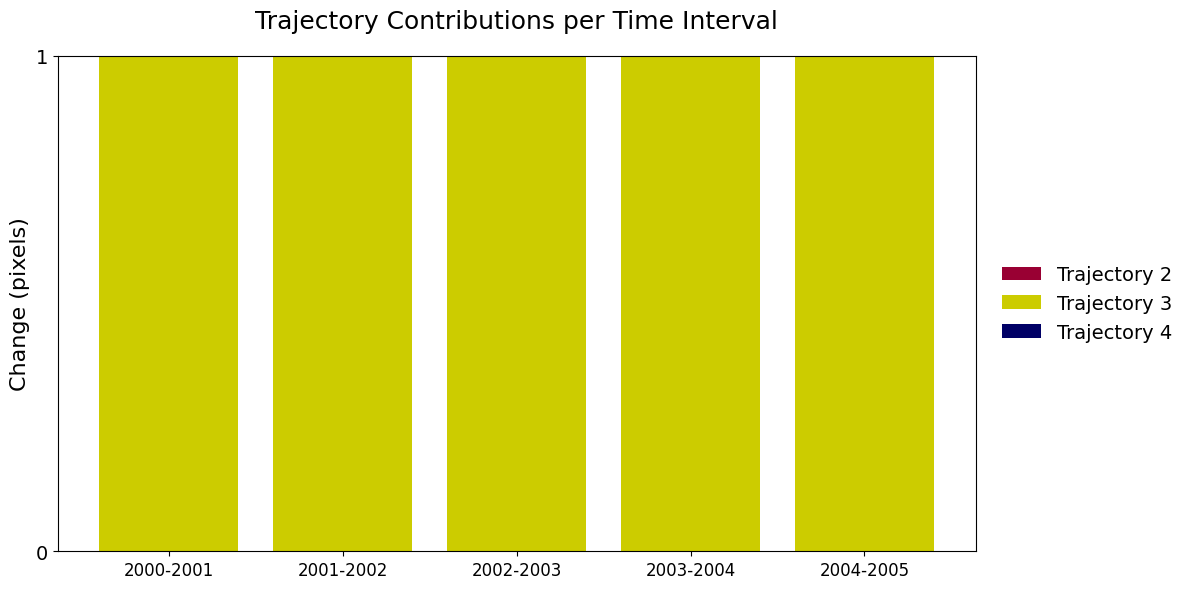

Figure saved to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/graphic_trajectory_contributions_stacked_bar.jpeg


In [23]:
def plot_trajectory_contributions(
    df: pd.DataFrame,
    output_path: str,
) -> None:
    """
    Create stacked bar chart for trajectory contributions per interval.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with intervals as index and trajectory IDs (2, 3, 4) as columns.
    output_path : str
        Path to output directory for saving figure.
    """
    # 0. Ensure columns are integers to match logic
    df = df.copy()
    df.columns = df.columns.astype(
        int,
    )

    # 1. Calculate the maximum value to determine scale factor
    max_val = df.sum(
        axis=1,
    ).max()

    if max_val >= 1_000_000:
        scale_factor = 1_000_000.0
        y_label = "Change (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000.0
        y_label = "Change (thousand pixels)"
    elif max_val >= 100:
        scale_factor = 100.0
        y_label = "Change (hundred pixels)"
    else:
        scale_factor = 1.0
        y_label = "Change (pixels)"

    # Apply scaling
    df_scaled = df / scale_factor

    # 2. Define colors and stacking order
    colors = {
        2: "#990033",
        3: "#cccc00",
        4: "#000066",
    }

    # Stacking order: 4 (bottom), 3 (middle), 2 (top)
    stack_order = [
        4,
        3,
        2,
    ]

    # 3. Create figure and axis
    fig, ax = plt.subplots(
        figsize=(
            12,
            6,
        ),
    )

    # 4. Plot stacked bars
    bottom = pd.Series(
        0.0,
        index=df_scaled.index,
    )

    for traj_id in stack_order:
        if traj_id in df_scaled.columns:
            values = df_scaled[
                traj_id
            ]
            ax.bar(
                df_scaled.index,
                values,
                label=f"Trajectory {traj_id}",
                bottom=bottom,
                color=colors[
                    traj_id
                ],
                edgecolor="none",
                width=0.8,
            )
            bottom += values

    # 5. Customize axes and labels
    ax.set_ylabel(
        y_label,
        fontsize=16,
    )
    ax.set_title(
        "Trajectory Contributions per Time Interval",
        fontsize=18,
        pad=20,
    )

    # X-Axis formatting: Horizontal labels
    ax.tick_params(
        axis="x",
        labelsize=12,
        rotation=0,
    )

    # Y-Axis formatting (mticker)
    ax.tick_params(
        axis="y",
        labelsize=14,
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            integer=True,
            nbins=5,
        ),
    )
    ax.yaxis.set_major_formatter(
        mticker.FormatStrFormatter(
            "%d",
        ),
    )

    # Spines visible, NO GRID
    for spine in [
        "top",
        "right",
        "left",
        "bottom",
    ]:
        ax.spines[
            spine
        ].set_visible(
            True,
        )

    # 6. Legend
    handles, labels = ax.get_legend_handles_labels()

    if handles:
        # Reorder handles to match 2, 3, 4
        legend_order_map = {
            "Trajectory 2": 0,
            "Trajectory 3": 1,
            "Trajectory 4": 2,
        }

        # Sort handles based on labels
        sorted_pairs = sorted(
            zip(
                handles,
                labels,
            ),
            key=lambda x: legend_order_map.get(
                x[1],
                99,
            ),
        )
        sorted_handles, sorted_labels = zip(
            *sorted_pairs,
        )

        ax.legend(
            sorted_handles,
            sorted_labels,
            loc="center left",
            bbox_to_anchor=(
                1.01,
                0.5,
            ),
            fontsize=14,
            frameon=False,
        )

    plt.tight_layout()

    # 7. Save figure
    output_fig = os.path.join(
        output_path,
        "graphic_trajectory_contributions_stacked_bar.jpeg",
    )
    plt.savefig(
        output_fig,
        dpi=300,
        bbox_inches="tight",
        format="jpeg",
    )
    plt.show()

    print(
        f"Figure saved to: {output_fig}",
    )


# EXECUTION
plot_trajectory_contributions(
    df=df_trajectory_intervals,
    output_path=output_path,
)

## **9. Alternation Maps**

### 9.1 Alternation Exchange

#### Compute Alternation Exchange raster map

In [24]:
# Define the output filename for the Alternation Exchange map
output_filename = os.path.join(
    output_path,
    "map_alternation_exchange.tif"
)

print(
    f"Starting generation of Alternation Exchange map: {output_filename}"
)

# 1. Setup and Metadata Reading
with rasterio.open(
    image_paths[0]
) as src:
    profile = src.profile
    height = src.height
    width = src.width

    # Update profile to use Byte (uint8) and set NoData to 255
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        nodata=noData_value
    )

# 2. Load all rasters into a 3D stack
stack_list = []
for path in image_paths:
    with rasterio.open(
        path
    ) as src:
        data = src.read(
            1
        )
        stack_list.append(
            data
        )

stack_data = np.array(
    stack_list
)

# 3. Initialize Output Array
output_map = np.full(
    (height, width),
    noData_value,
    dtype=np.uint8
)

# 4. Create Mask for Valid Pixels
valid_mask = np.all(
    stack_data != noData_value,
    axis=0
)

rows, cols = np.where(
    valid_mask
)

# 5. Pixel-by-Pixel Processing
for r, c in tqdm(
    zip(
        rows,
        cols
    ),
    total=len(
        rows
    ),
    desc="Processing pixels"
):
    traj = stack_data[
        :,
        r,
        c
    ]

    unique_classes = np.unique(
        traj
    )
    class_map = {
        cls: i for i, cls in enumerate(
            unique_classes
        )
    }
    n = len(
        unique_classes
    )

    m_r = np.zeros(
        (n, n)
    )
    e_r = np.zeros(
        (n, n)
    )

    # Populate Transition Matrix
    for t in range(
        len(
            traj
        ) - 1
    ):
        s = class_map[
            traj[t]
        ]
        e = class_map[
            traj[t + 1]
        ]

        if s != e:
            m_r[
                s,
                e
            ] += 1

    # Populate Extension Matrix
    start_idx = class_map[
        traj[0]
    ]
    end_idx = class_map[
        traj[-1]
    ]
    e_r[
        start_idx,
        end_idx
    ] += 1

    # Calculate Alternation Exchange (ax_r)
    ax_r = np.minimum(
        m_r,
        m_r.T
    )

    # Calculate total exchange
    total_exchange = np.sum(
        ax_r
    )

    # Assign the calculated value directly
    output_map[r, c] = total_exchange

# 6. Save the Result to GeoTIFF
with rasterio.open(
    output_filename,
    'w',
    **profile
) as dst:
    dst.write(
        output_map,
        1
    )

print(
    f"Process completed. Alternation Exchange map saved to: {output_filename}"
)

Starting generation of Alternation Exchange map: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_alternation_exchange.tif


Processing pixels: 100%|██████████| 1/1 [00:00<00:00, 2874.78it/s]


Process completed. Alternation Exchange map saved to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_alternation_exchange.tif


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


#### Plot Alternation Exchange map

Reading Alternation Exchange map for plotting: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_alternation_exchange.tif


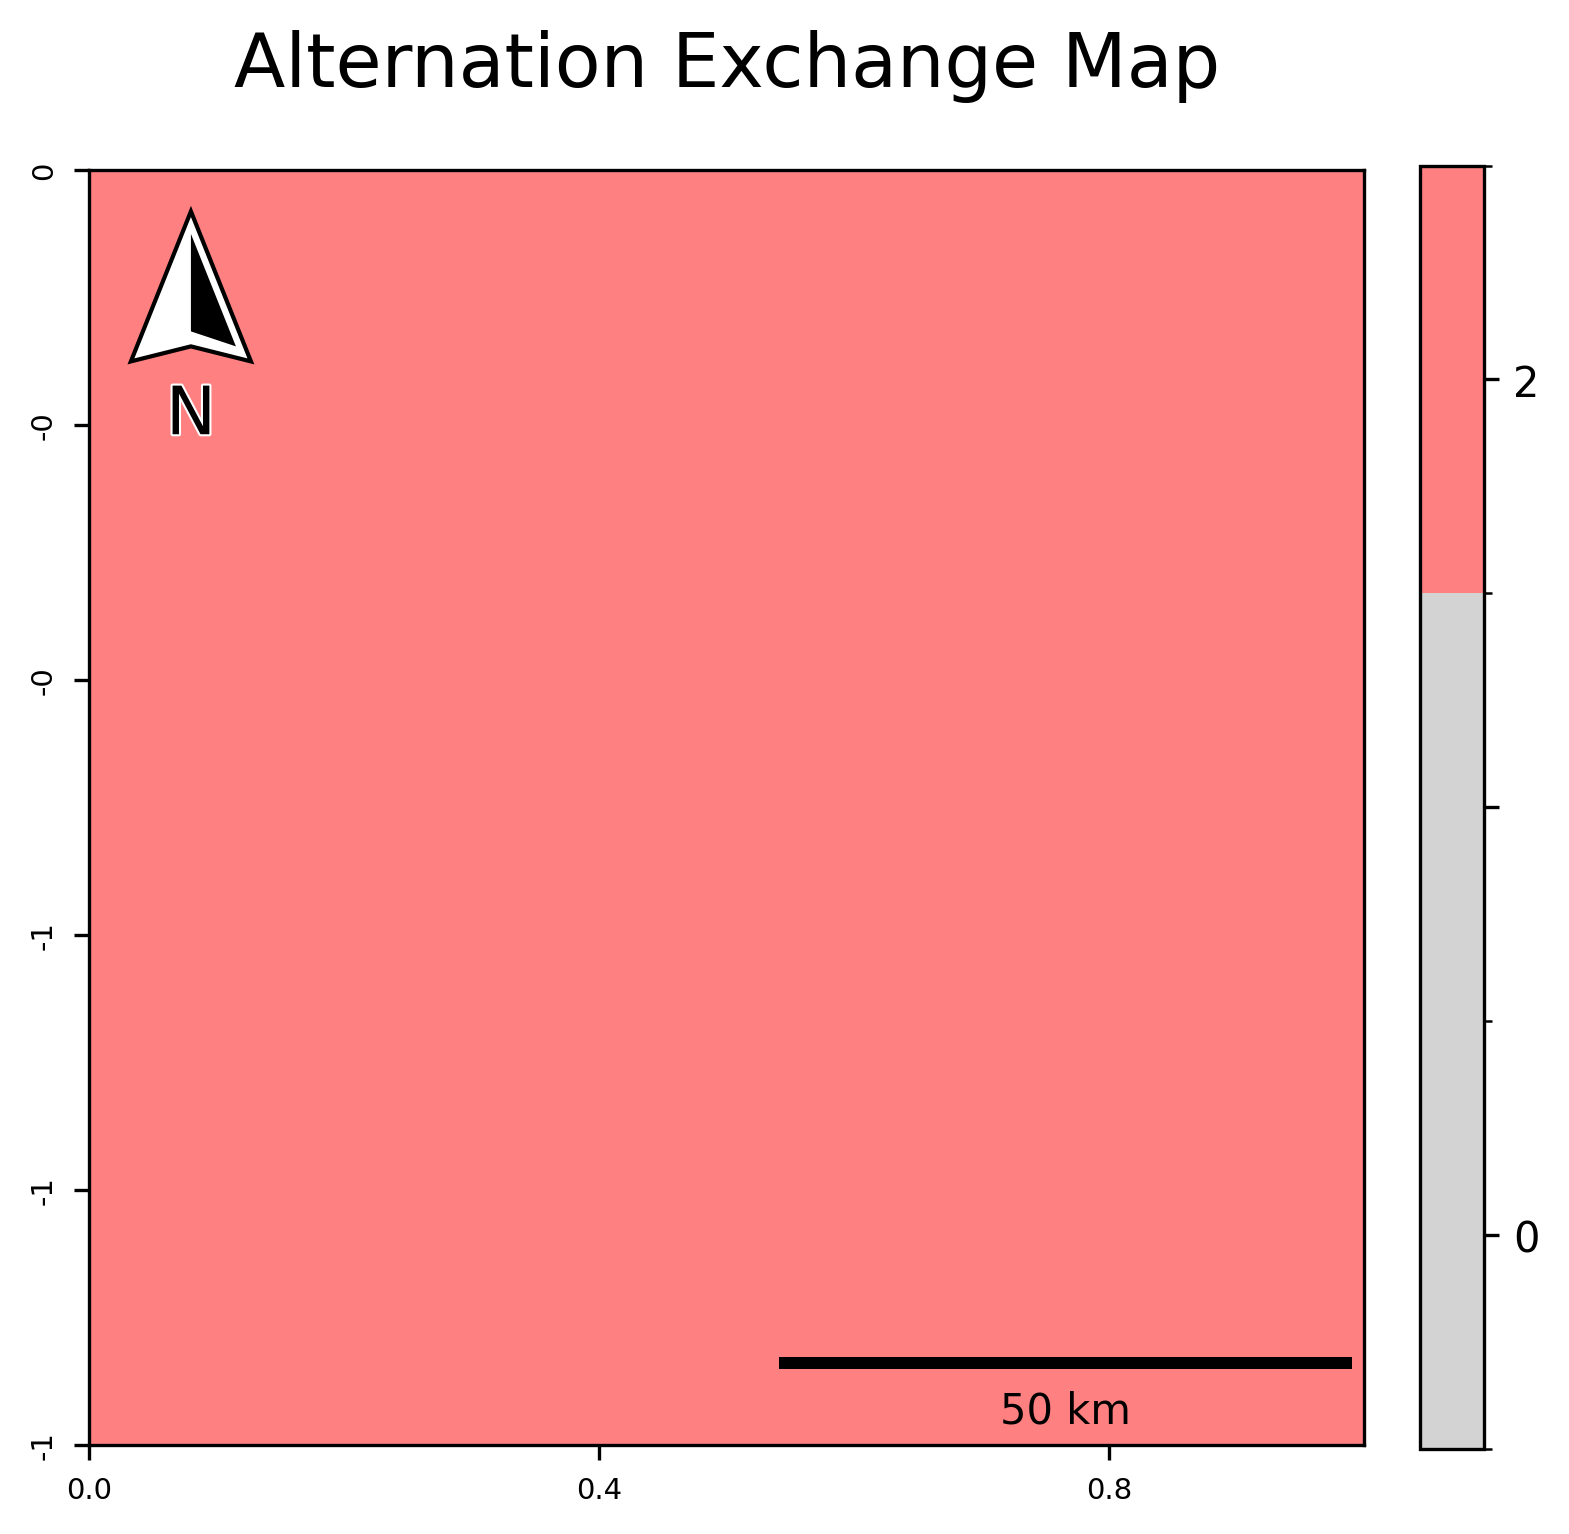

Map successfully saved to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_alternation_exchange.png


In [25]:
def plot_alternation_exchange_discrete_map(
    output_dir: str,
    raster_filename: str = "map_alternation_exchange.tif",
) -> None:
    """
    Plot the Alternation Exchange map using a discrete integer scale.

    The visualization uses a specific color logic where the value 0 is
    represented in gray (indicating stability or absence of exchange),
    while values greater than or equal to 1 are represented by a
    gradient color scale (e.g., from pink to dark red) to indicate
    the intensity of the exchange.

    Parameters
    ----------
    output_dir : str
        The directory path containing the input raster file and where
        the output image will be saved.
    raster_filename : str, optional
        The filename of the raster to be plotted (default is
        "map_alternation_exchange.tif").

    Returns
    -------
    None
        The function saves a PNG image to the output directory and
        displays the plot.

    Raises
    ------
    FileNotFoundError
        If the specified raster file does not exist in the output directory.
    """
    # 1. Input Validation and Path Setup
    raster_path = os.path.join(
        output_dir,
        raster_filename,
    )

    if not os.path.exists(
        raster_path,
    ):
        raise FileNotFoundError(
            f"Raster not found: {raster_path}",
        )

    print(
        f"Reading Alternation Exchange map for plotting: {raster_path}",
    )

    # 2. Data Loading and Masking
    with rasterio.open(
        raster_path,
    ) as src:
        scale_factor = 1
        data = src.read(
            1,
            out_shape=(
                int(src.height * scale_factor),
                int(src.width * scale_factor),
            ),
            resampling=rasterio.enums.Resampling.nearest,
        )

        # Retrieve NoData value (defaulting to 255 if not defined)
        nodata = src.nodata if src.nodata is not None else 255

        # Mask only the NoData values.
        # It is crucial to keep 0 values unmasked as they represent valid data.
        data_masked = np.ma.masked_equal(
            data,
            nodata,
        )

        left, bottom, right, top = src.bounds
        src_crs = src.crs
        transform = src.transform

    # Determine the integer range for the color scale
    data_max = int(
        data_masked.max(),
    )

    # Ensure at least 1 to prevent errors if the map is empty/flat
    if data_max == 0:
        data_max = 1

    # 3. Discrete Colormap Configuration
    # Define the color for value 0 (Background/Gray)
    colors_list = [
        "#d3d3d3",
    ]

    # Generate gradient colors for values >= 1
    if data_max >= 1:
        # Create a linear gradient from Pink to Dark Red
        cmap_base = mcolors.LinearSegmentedColormap.from_list(
            "exchange_gradient",
            [
                "#fe8081",
                "#67000d",
            ],
        )

        for i in range(1, data_max + 1):
            if i < 2:
                # Value 1 is theoretically impossible for Exchange (must be pairs).
                # We assign Gray just in case, or to keep it neutral before the gradient starts.
                colors_list.append("#d3d3d3")
            else:
                # For values >= 2:
                # Value 2 becomes the start of the gradient (0.0 -> Pink)
                # Value data_max becomes the end (1.0 -> Dark Red)
                denominator = max(1, data_max - 2)
                fraction = (i - 2) / denominator

                colors_list.append(
                    mcolors.to_hex(
                        cmap_base(
                            fraction,
                        ),
                    ),
                )

    # Create the custom discrete colormap
    cmap = ListedColormap(
        colors_list,
    )

    # 4. Define Boundaries (Bins) for Integers
    # Create boundaries for every integer from 0 to max + 1
    bounds = np.arange(
        0,
        data_max + 2,
    )
    norm = BoundaryNorm(
        bounds,
        cmap.N,
    )

    # 5. Plotting the Figure
    fig, ax = plt.subplots(
        figsize=(
            6,
            8,
        ),
        dpi=300,
    )

    im = ax.imshow(
        data_masked,
        extent=[
            left,
            right,
            bottom,
            top,
        ],
        cmap=cmap,
        norm=norm,
        interpolation="nearest",
    )

    # 6. Legend (Colorbar) Configuration
    cbar = plt.colorbar(
        im,
        ax=ax,
        orientation="vertical",
        fraction=0.046,
        pad=0.04,
        ticks=bounds[:-1] + 0.5,  # Center ticks in the color block
    )
    #cbar.set_label(
    #    "Intensity of Exchange (Integer Count)",
    #    rotation=270,
    #    labelpad=15,
    #    fontsize=9,
    #)

    # Prepare labels: create labels for all integer bins and make odd ones empty for 'even ticks' effect
    all_integer_labels = np.arange(0, data_max + 1)
    even_ticks_values = np.arange(0, data_max + 1, 2)
    labels_to_show = [str(x) if x in even_ticks_values else '' for x in all_integer_labels]

    # Set tick labels to display integer values only (or empty for odd)
    cbar.set_ticklabels(
        labels_to_show,
    )

    # 7. Cartographic Elements (Scale Bar)
    # Determine pixel size in meters for scale bar calculation
    if src_crs and src_crs.is_projected:
        pixel_size_m = transform.a
    else:
        # Fallback to WGS84 geodesic calculation
        geod = Geod(
            ellps="WGS84",
        )
        crs_ll = CRS.from_epsg(
            4326,
        )

        if src_crs:
            transformer_ll = Transformer.from_crs(
                src_crs,
                crs_ll,
                always_xy=True,
            )
        else:
            transformer_ll = None

        xc = (left + right) / 2.0
        yc = (bottom + top) / 2.0

        if transformer_ll:
            lon_c, lat_c = transformer_ll.transform(
                xc,
                yc,
            )
            lon_r, _ = transformer_ll.transform(
                xc + transform.a,
                yc,
            )
        else:
            lon_c, lat_c = xc, yc
            lon_r = xc + transform.a

        _, _, dist_m = geod.inv(
            lon_c,
            lat_c,
            lon_r,
            lat_c,
        )
        pixel_size_m = dist_m

    scalebar = ScaleBar(
        dx=pixel_size_m / 1000.0,
        units="km",
        length_fraction=0.5,
        location="lower right",
        box_alpha=0.0,
        scale_formatter=lambda value, _: f"{int(value)} km",
    )
    ax.add_artist(
        scalebar,
    )

    # 8. North Arrow
    north_arrow(
        ax,
        location="upper left",
        shadow=False,
        rotation={
            "degrees": 0,
        },
    )

    # 9. Final Styling and Saving
    ax.set_title(
        "Alternation Exchange Map",
        fontsize=18,
        pad=20,
    )
    ax.set_aspect(
        "equal",
    )
    # Axis formatting
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        pad=4,
    )
    ax.xaxis.set_major_locator(
        mticker.MaxNLocator(
            3,
        ),
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            6,
        ),
    )
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(
            lambda y, pos: f"{y:.0f}",
        ),
    )
    plt.setp(
        ax.get_yticklabels(),
        rotation=90,
        va="center",
    )

    output_figure_path = os.path.join(
        output_dir,
        "map_alternation_exchange.png",
    )

    plt.savefig(
        output_figure_path,
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.5,
    )
    plt.show()

    print(
        f"Map successfully saved to: {output_figure_path}",
    )

# Execute the function
plot_alternation_exchange_discrete_map(
    output_path,
)


### 9.2 Alternation Shift Map

#### Compute Alternation Shift raster map

In [26]:
# Define the output filename for the Alternation map
output_filename_shift = os.path.join(
    output_path,
    "map_alternation_shift.tif",
)

print(
    f"Starting generation of Alternation Shift map: {output_filename_shift}",
)

# 1. Setup and Metadata Reading
with rasterio.open(
    image_paths[0],
) as src:
    profile = src.profile
    height = src.height
    width = src.width

    # Update profile to use Byte (uint8) and set NoData to the variable value.
    # We maintain NoData=255 to ensure that 0 (No Shift) is visible as a valid value.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        nodata=noData_value,
    )

# 2. Load all rasters into a 3D stack
stack_list = []
for path in image_paths:
    with rasterio.open(
        path,
    ) as src:
        data = src.read(
            1,
        )
        stack_list.append(
            data,
        )

stack_data = np.array(
    stack_list,
)

# 3. Initialize Output Array
# Initialize with NoData value
# Valid pixels will be overwritten with 0, 1, 2, etc.
output_map_shift = np.full(
    (
        height,
        width,
    ),
    noData_value,
    dtype=np.uint8,
)

# 4. Create Mask for Valid Pixels
# Pixels are valid if they are not NoData in any of the time steps.
valid_mask = np.all(
    stack_data != noData_value,
    axis=0,
)

rows, cols = np.where(
    valid_mask,
)

# 5. Pixel-by-Pixel Processing
for r, c in tqdm(
    zip(
        rows,
        cols,
    ),
    total=len(
        rows,
    ),
    desc="Processing Shift pixels",
):
    traj = stack_data[
        :,
        r,
        c,
    ]

    unique_classes = np.unique(
        traj,
    )
    class_map = {
        cls: i for i, cls in enumerate(
            unique_classes,
        )
    }
    n = len(
        unique_classes,
    )

    m_r = np.zeros(
        (
            n,
            n,
        ),
    )

    # Populate Transition Matrix
    for t in range(
        len(
            traj,
        ) - 1,
    ):
        s = class_map[
            traj[t]
        ]
        e = class_map[
            traj[t + 1]
        ]

        if s != e:
            m_r[
                s,
                e,
            ] += 1

    # Extension Setup (Start vs End)
    start_idx = class_map[
        traj[0]
    ]
    end_idx = class_map[
        traj[-1]
    ]

    # Calculate Alternation component for Exchange logic
    # We keep the matrix logic for 'a_r' to ensure 'ax_r' is calculated correctly.
    e_r_matrix = np.zeros(
        (
            n,
            n,
        ),
    )
    a_r = m_r - e_r_matrix

    # Calculate Alternation Exchange (ax_r)
    # This captures the oscillating changes (e.g., A->B->A).
    ax_r = np.minimum(
        m_r,
        m_r.T,
    )

    # 1. Total Changes: The sum of all transitions in the trajectory.
    total_changes = np.sum(
        m_r,
    )

    # 2. Net Extension Amount:
    # If it started and ended at the same place, net extension is 0.
    # If it ended elsewhere, net extension counts as 1.
    extension_amount = 1 if start_idx != end_idx else 0

    # 3. Total Exchange: Sum of the Exchange matrix calculated above.
    total_exchange = np.sum(
        ax_r,
    )

    # 4. Calculate Scalar Shift
    # Formula: Shift = (Total Changes) - (Net Extension) - (Total Exchange)
    # Example A->B->C: 2 (changes) - 1 (extension) - 0 (exchange) = 1 (Shift)
    # Example A->B->A: 2 (changes) - 0 (extension) - 2 (exchange) = 0 (Shift)
    total_shift = total_changes - extension_amount - total_exchange

    # Safety check to prevent negative values due to floating point nuances
    total_shift = max(
        0,
        total_shift,
    )

    # Assign value directly
    # Writes 0, 1, 2... to the pixel.
    output_map_shift[
        r,
        c,
    ] = total_shift

# 6. Save the Result to GeoTIFF
with rasterio.open(
    output_filename_shift,
    'w',
    **profile,
) as dst:
    dst.write(
        output_map_shift,
        1,
    )

print(
    f"Process completed. Alternation Shift map saved to: {output_filename_shift}",
)

Starting generation of Alternation Shift map: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_alternation_shift.tif


Processing Shift pixels: 100%|██████████| 1/1 [00:00<00:00, 3090.87it/s]


Process completed. Alternation Shift map saved to: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_alternation_shift.tif


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


#### Plot Alternation Shift map

Reading Alternation Shift map for plotting: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_alternation_shift.tif


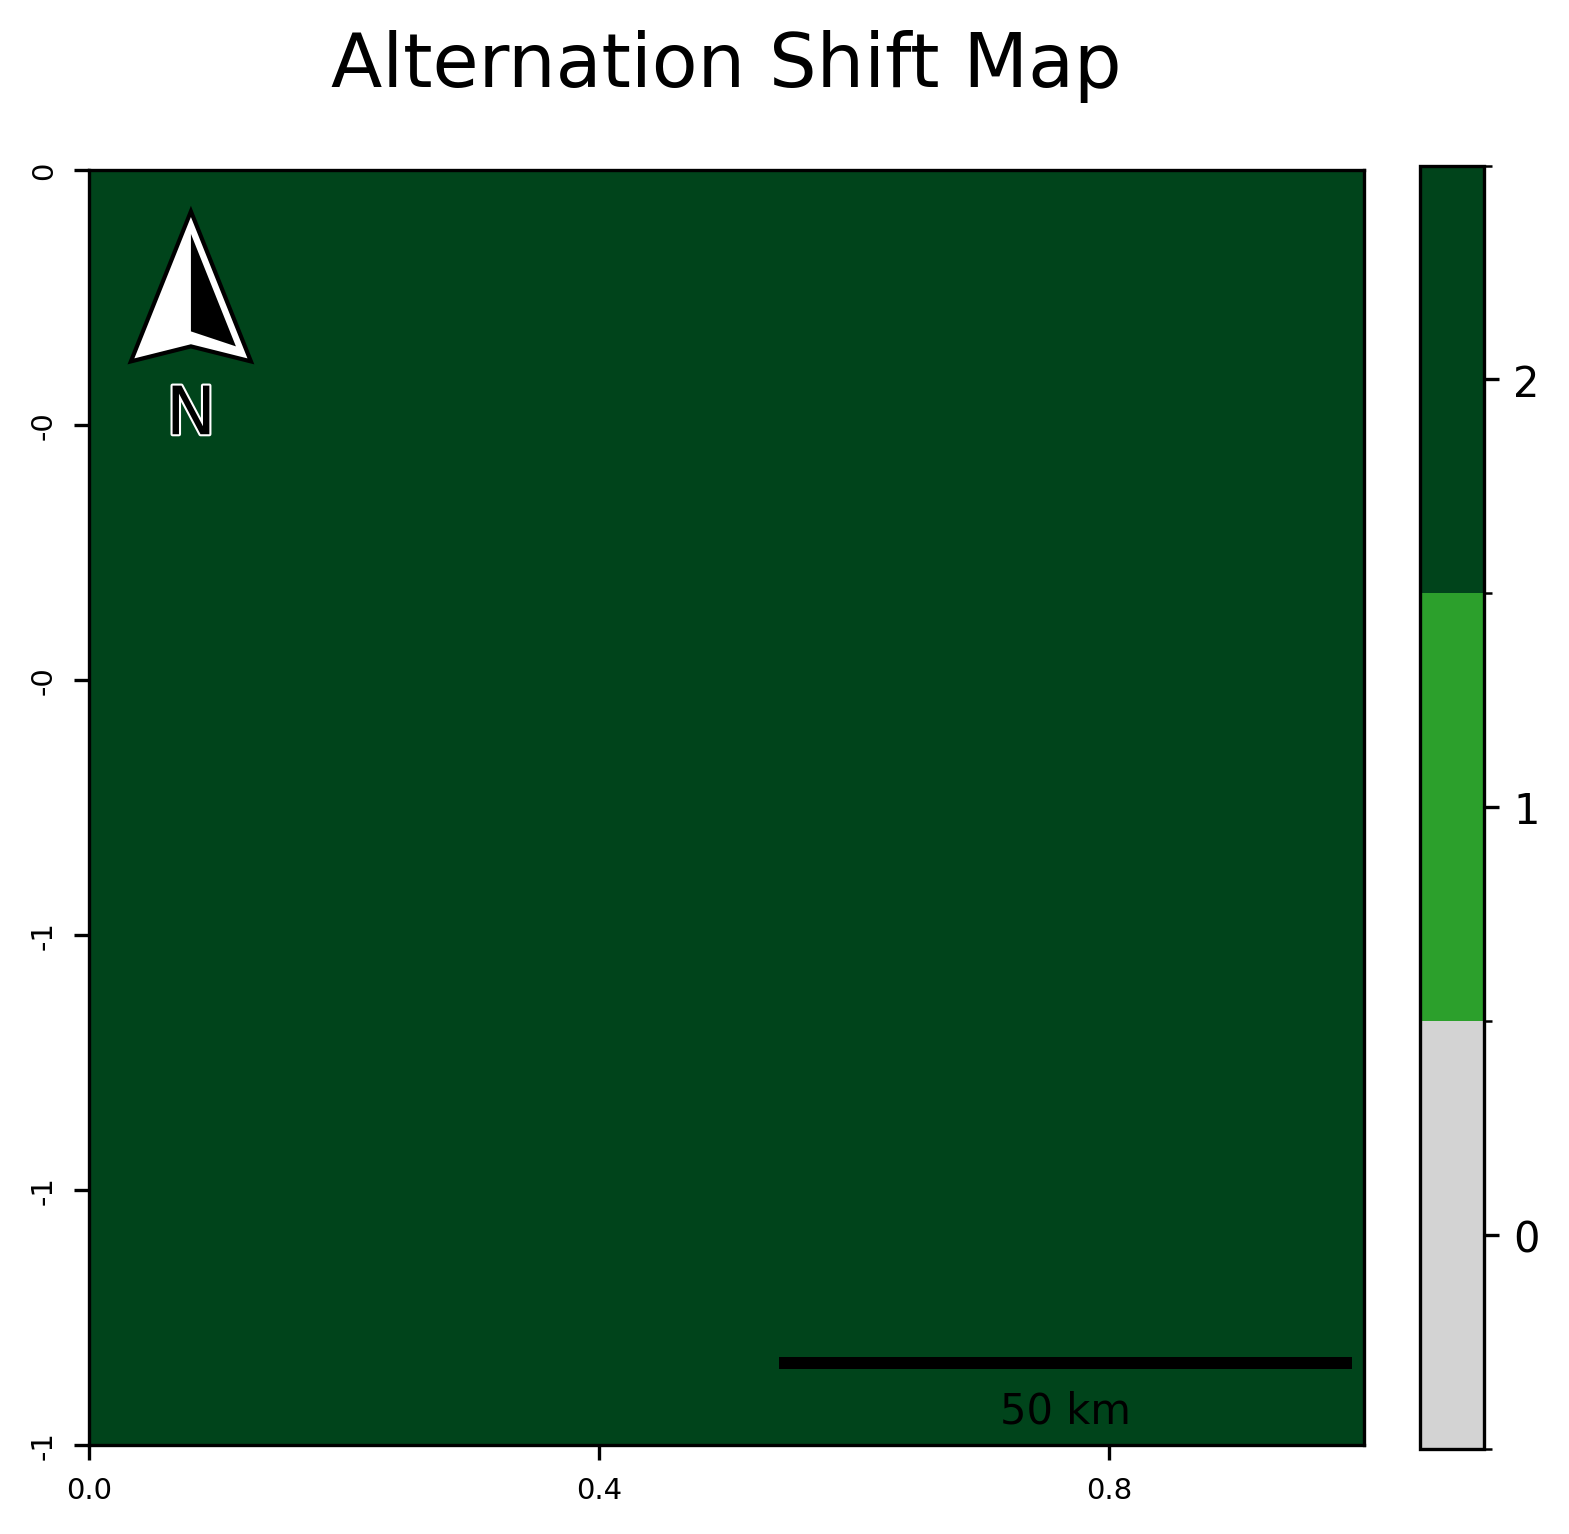

Map saved successfully: /content/drive/MyDrive/Assesssments/cca/output/toydata5/map_alternation_shift.png


In [27]:
def plot_alternation_shift_map(
    output_dir: str,
    raster_filename: str = "map_alternation_shift.tif",
) -> None:
    """
    Plot the Alternation Shift map using a discrete integer scale.

    The visualization uses a specific color logic where the value 0 is
    represented in gray (indicating stability or absence of shift),
    while values greater than or equal to 1 are represented by a
    gradient color scale (e.g., from green to dark green) to indicate
    the intensity of the shift.

    Parameters
    ----------
    output_dir : str
        The directory path containing the input raster file and where
        the output image will be saved.
    raster_filename : str, optional
        The filename of the raster to be plotted (default is
        "map_alternation_shift.tif").

    Returns
    -------
    None
        The function saves a PNG image to the output directory and
        displays the plot.

    Raises
    ------
    FileNotFoundError
        If the specified raster file does not exist in the output directory.
    """
    # 1. Input Validation and Path Setup
    raster_path = os.path.join(
        output_dir,
        raster_filename,
    )

    if not os.path.exists(
        raster_path,
    ):
        raise FileNotFoundError(
            f"Raster not found: {raster_path}",
        )

    print(
        f"Reading Alternation Shift map for plotting: {raster_path}",
    )

    # 2. Data Loading and Masking
    with rasterio.open(
        raster_path,
    ) as src:
        scale_factor = 1
        data = src.read(
            1,
            out_shape=(
                int(src.height * scale_factor),
                int(src.width * scale_factor),
            ),
            resampling=rasterio.enums.Resampling.nearest,
        )

        # Retrieve NoData value (defaulting to 255 if not defined)
        nodata_val = src.nodata if src.nodata is not None else 255

        # Mask logic: Ensure 0 is NOT masked (it represents valid 'No Shift').
        # We assume 255 is the NoData/Background value.
        if nodata_val == 0:
            # If metadata incorrectly says 0 is NoData, we force mask on 255
            data_masked = np.ma.masked_equal(
                data,
                255,
            )
        else:
            data_masked = np.ma.masked_equal(
                data,
                nodata_val,
            )

        left, bottom, right, top = src.bounds
        src_crs = src.crs
        transform = src.transform

    # Determine the integer range for the color scale
    data_max = int(
        data_masked.max(),
    )

    # Ensure at least 1 to prevent errors if the map is empty/flat
    if data_max == 0:
        data_max = 1

    # 3. Discrete Colormap Configuration
    # Define the color for value 0 (Background/Gray)
    colors_list = [
        "#d3d3d3",
    ]

    # Generate gradient colors for values >= 1 (Green Spectrum)
    if data_max >= 1:
        # Create a linear gradient from Standard Green to Dark Green
        cmap_greens = mcolors.LinearSegmentedColormap.from_list(
            "greens_grad",
            [
                "#2ca02c",
                "#00441b",
            ],
        )

        for i in range(
            data_max,
        ):
            # Sample colors from the gradient based on the range magnitude
            fraction = i / max(
                1,
                data_max - 1,
            )
            colors_list.append(
                mcolors.to_hex(
                    cmap_greens(
                        fraction,
                    ),
                ),
            )

    # Create the custom discrete colormap
    cmap = ListedColormap(
        colors_list,
    )

    # 4. Define Boundaries (Bins) for Integers
    # Create boundaries for every integer from 0 to max + 1
    bounds = np.arange(
        0,
        data_max + 2,
    )
    norm = BoundaryNorm(
        bounds,
        cmap.N,
    )

    # 5. Plotting the Figure
    fig, ax = plt.subplots(
        figsize=(
            6,
            8,
        ),
        dpi=300,
    )

    im = ax.imshow(
        data_masked,
        extent=[
            left,
            right,
            bottom,
            top,
        ],
        cmap=cmap,
        norm=norm,
        interpolation="nearest",
    )

    # 6. Legend (Colorbar) Configuration
    cbar = plt.colorbar(
        im,
        ax=ax,
        orientation="vertical",
        fraction=0.046,
        pad=0.04,
        ticks=bounds[:-1] + 0.5,  # Center ticks in the color block
    )
    #cbar.set_label(
    #    "Intensity of Alternation Shift (Count)",
    #    rotation=270,
    #    labelpad=15,
    #    fontsize=9,
    #)
    # Set tick labels to display integer values only
    cbar.set_ticklabels(
        np.arange(
            0,
            data_max + 1,
        ),
    )

    # 7. Cartographic Elements (Scale Bar)
    if src_crs and src_crs.is_projected:
        pixel_size_m = transform.a
    else:
        # Fallback to WGS84 geodesic calculation
        geod = Geod(
            ellps="WGS84",
        )
        crs_ll = CRS.from_epsg(
            4326,
        )

        if src_crs:
            transformer_ll = Transformer.from_crs(
                src_crs,
                crs_ll,
                always_xy=True,
            )
        else:
            transformer_ll = None

        xc = (left + right) / 2.0
        yc = (bottom + top) / 2.0

        if transformer_ll:
            lon_c, lat_c = transformer_ll.transform(
                xc,
                yc,
            )
            lon_r, _ = transformer_ll.transform(
                xc + transform.a,
                yc,
            )
        else:
            lon_c, lat_c = xc, yc
            lon_r = xc + transform.a

        _, _, dist_m = geod.inv(
            lon_c,
            lat_c,
            lon_r,
            lat_c,
        )
        pixel_size_m = dist_m

    scalebar = ScaleBar(
        dx=pixel_size_m / 1000.0,
        units="km",
        length_fraction=0.5,
        location="lower right",
        box_alpha=0.0,
        scale_formatter=lambda value, _: f"{int(value)} km",
    )
    ax.add_artist(
        scalebar,
    )

    # 8. North Arrow
    north_arrow(
        ax,
        location="upper left",
        shadow=False,
        rotation={
            "degrees": 0,
        },
    )

    # 9. Final Styling and Saving
    ax.set_title(
        "Alternation Shift Map",
        fontsize=18,
        pad=20,
    )
    ax.set_aspect(
        "equal",
    )

    # Axis formatting
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        pad=4,
    )
    ax.xaxis.set_major_locator(
        mticker.MaxNLocator(
            3,
        ),
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            6,
        ),
    )
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(
            lambda y, pos: f"{y:.0f}",
        ),
    )
    plt.setp(
        ax.get_yticklabels(),
        rotation=90,
        va="center",
    )

    output_figure_path = os.path.join(
        output_dir,
        "map_alternation_shift.png",
    )

    plt.savefig(
        output_figure_path,
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.5,
    )
    plt.show()

    print(
        f"Map saved successfully: {output_figure_path}",
    )

# Execute the function
plot_alternation_shift_map(
    output_dir=output_path,
    raster_filename="map_alternation_shift.tif",
)